### Introduction: This is the Jupyter notebook to do the flowing things:

1. Read slimmed PKU Tree files to plot pre-fit results
2. Store the pre-fit shapes histograms to pickle files

Note that CR is taken as tagger score 0.6-0.8, this is because SR is taken from tagger score > 0.8, and the QCD shape in 0.6-0.8 is considered similar with SR.



### Import necessary modules

In [1]:
import numpy as np
import os
import pandas as pd
import random
import awkward as ak
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
from scipy import interpolate
# from sklearn.metrics import roc_curve, auc
from cycler import cycler
import uproot
# means uproot4
import ROOT
import argparse
import glob
import json
import logging
import os
import pickle as pkl
import warnings

import hist as hist2
import pyarrow
# import utils #local file: utils.py
import yaml
from typing import Dict, List, Union
from dataclasses import dataclass
from copy import deepcopy

# from coffea import hist
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.nanoevents.methods import vector
# from coffea.nanoevents.methods.vector import PtEtaPhiMLorentzVector

Welcome to JupyROOT 6.28/04


### Read SlimmedTree files

In [2]:
CustNanoData = {
    'data'        : "/ospool/cms-user/yuzhe/SlimmedTree/V5/Full-Run2/Data/SlimmedTree_Data.root",
    'QCD'         : "/ospool/cms-user/yuzhe/SlimmedTree/V5/Full-Run2/MC/SlimmedTree_QCD.root",          
    'Top'         : "/ospool/cms-user/yuzhe/SlimmedTree/V5/Full-Run2/MC/SlimmedTree_Top.root",
    'WJets'       : "/ospool/cms-user/yuzhe/SlimmedTree/V5/Full-Run2/MC/SlimmedTree_WJets.root",
    'Rest'        : "/ospool/cms-user/yuzhe/SlimmedTree/V5/Full-Run2/MC/SlimmedTree_Rest.root",
    'TotalSignal' : "/ospool/cms-user/yuzhe/SlimmedTree/V5/Full-Run2/Signal/SlimmedTree_Total.root",
    'ggF'         : "/ospool/cms-user/yuzhe/SlimmedTree/V5/Full-Run2/Signal/SlimmedTree_GluGlu.root",
    'VH'          : "/ospool/cms-user/yuzhe/SlimmedTree/V5/Full-Run2/Signal/SlimmedTree_VH.root",   
    'ttH'         : "/ospool/cms-user/yuzhe/SlimmedTree/V5/Full-Run2/Signal/SlimmedTree_ttH.root",
    'VBF'         : "/ospool/cms-user/yuzhe/SlimmedTree/V5/Full-Run2/Signal/SlimmedTree_VBF.root",
}
BKG = ["QCD","Top","WJets","Rest"]
files = {typefile : {} for typefile in CustNanoData}
for typefile in CustNanoData:
    files[typefile] = uproot.lazy({CustNanoData[typefile]: "PKUTree" })

### Get DPhi in the events

In [3]:
def get_dphi(events):
    pT_higgs   = events["PTj_V2_a"]
    eta_higgs  = events["Etaj_V2_a"]
    phi_higgs  = events["Phij_V2_a"]
    mass_higgs = events["Mj_V2_a"]
    pT_MET = events["MET_et"]
    eta_MET = events["Etaj_V2_a"]
    phi_MET = events["MET_phi"]
    mass_MET = ak.zeros_like(events["MET_phi"])
    vec_higgs = ak.zip({
        "pt"   : pT_higgs   ,
        "eta"  : eta_higgs  ,
        "phi"  : phi_higgs  ,
        "mass" : mass_higgs ,
    },
    with_name="PtEtaPhiMLorentzVector",
    behavior=vector.behavior,
    )
    vec_MET = ak.zip({
        "pt"   :   pT_MET   ,
        "eta"  :  eta_MET  ,
        "phi"  :  phi_MET  ,
        "mass" : mass_MET ,
    },
    with_name="PtEtaPhiMLorentzVector",
    behavior=vector.behavior,
    )
    delta_phi = np.subtract(vec_MET.phi, vec_higgs.phi)
    delta_phi = np.where(delta_phi > np.pi, delta_phi - 2*np.pi, delta_phi)
    delta_phi = np.where(delta_phi < -np.pi, delta_phi + 2*np.pi, delta_phi)
    delta_phi = np.abs(delta_phi)
    print(delta_phi)
    events["DPhi"] = delta_phi

for k in files:
    print("Add dphi of:",k)
    get_dphi(events=files[k])

Add dphi of: data


[0.597, 0.363, 0.458, 1.07, 2.84, 0.341, ... 0.767, 0.2, 0.504, 3.03, 0.289, 0.0353]
Add dphi of: QCD
[2.8, 2.58, 0.514, 2.3, 3.01, 0.305, 0.629, ... 0.0396, 3.07, 0.765, 3, 2.96, 3.07]
Add dphi of: Top
[0.377, 0.707, 0.49, 2.48, 2.35, 2.75, 2.95, ... 0.169, 2.6, 2.94, 1.61, 1.35, 3.05]
Add dphi of: WJets
[2.81, 0.123, 1.6, 0.0544, 2.76, 2.51, ... 2.74, 0.508, 2.42, 1.41, 2.56, 0.258]
Add dphi of: Rest
[2.56, 1.73, 0.401, 3.13, 3.03, 2.83, 1.66, ... 1.26, 1.24, 0.0949, 2.46, 1.87, 2.91]
Add dphi of: TotalSignal
[2.4, 1.87, 3.06, 3.04, 2.91, 1.51, 2.08, ... 3.1, 0.141, 0.273, 0.498, 1.18, 2.73]
Add dphi of: ggF
[2.4, 1.87, 3.06, 3.04, 2.91, 1.51, 2.08, ... 3.09, 0.722, 3, 3.11, 3.07, 0.455]
Add dphi of: VH
[0.168, 1.39, 2.76, 1.26, 0.0118, 2.83, ... 3.1, 0.141, 0.273, 0.498, 1.18, 2.73]
Add dphi of: ttH
[3.12, 2.62, 2.28, 2.03, 0.0168, 0.16, ... 0.743, 0.839, 2.31, 2.44, 2.99, 0.506]
Add dphi of: VBF
[2.97, 2.31, 0.0849, 0.17, 0.0194, 0.481, ... 1.13, 0.332, 2.5, 2.82, 2.01, 2.45]


In [4]:

def get_reco(events):
    pT_higgs   = events["PTj_V2_a"]
    eta_higgs  = events["Etaj_V2_a"]
    phi_higgs  = events["Phij_V2_a"]
    mass_higgs = events["Mj_V2_a"]
    pT_MET = events["MET_et"]
    eta_MET = events["Etaj_V2_a"]
    phi_MET = events["MET_phi"]
    mass_MET = ak.zeros_like(events["MET_phi"])
    vec_higgs = ak.zip({
        "pt"   : pT_higgs   ,
        "eta"  : eta_higgs  ,
        "phi"  : phi_higgs  ,
        "mass" : mass_higgs ,
    },
    with_name="PtEtaPhiMLorentzVector",
    behavior=vector.behavior,
    )

    vec_MET = ak.zip({
        "pt"   :   pT_MET   ,
        "eta"  :  eta_MET  ,
        "phi"  :  phi_MET  ,
        "mass" : mass_MET ,
    },
    with_name="PtEtaPhiMLorentzVector",
    behavior=vector.behavior,
    )

    vec_sum = vec_MET + vec_higgs
    mH_reco = vec_sum.mass
    events["MH_Reco"] = ak.where(( (events["DPhi"] < 0.8) & (events["MET_et"]/events["PTj_V2_a"] > 0.2)),mH_reco, events["Mj_V2_a"])
get_reco(files["QCD"]) 
print("done QCD")
get_reco(files["data"]) 
print("done data")  
get_reco(files["Top"])
get_reco(files["WJets"])
get_reco(files["Rest"])
# get_reco(files["WplusRest"])
print("done bkg") 
get_reco(files["TotalSignal"])
get_reco(files["ggF"])
get_reco(files["VH"])
get_reco(files["ttH"])
get_reco(files["VBF"])
print("done signal") 

done QCD


done data
done bkg
done signal


### some test about variables

In [5]:
files["VBF"]["DPhi"]

<Array [2.97, 2.31, 0.0849, ... 2.01, 2.45] type='17017 * float32'>

### plot setting

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
from cycler import cycler

use_helvet = False ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

def flow(hist: bh.Histogram, overflow: bool=False, underflow: bool=False):
    h, var = hist.view(flow=(overflow | underflow)).value, hist.view(flow=(overflow | underflow)).variance
    if overflow: 
        # h, var also include underflow bins but in plots usually no underflow data
        # And we've filled None with -999, so we shouldn't show underflow data (mostly from filled None)
        # You have to access the overflow and underflow bins data like below:
        h[-2] += h[-1]; var[-2] += var[-1]
    if underflow:
        h[1] += h[0]; var[1] += var[0]
    if overflow or underflow:
        h, var = h[1:-1], var[1:-1]
    return h, var
    # Return the updated histogram and variance

def error_bar(h, var, type='data'):
    from scipy.interpolate import CubicSpline
    if type == 'data':
        number = h
    elif type == 'mc':  # h = k*N, var = k^2*N, std = k*sqrt(N)
        number = h**2 / var
    else:
        raise ValueError("type should be 'data' or 'mc'! ")
    center = range(11) # Number: 0-10
    up = np.array([1.84, 3.30, 4.64, 5.92, 7.16, 8.38, 9.58, 10.77, 11.95, 13.11, 14.27]) - center
    down = center - np.array([0, 0.17, 0.71, 1.37, 2.09, 2.84, 3.62, 4.42, 5.23, 6.06, 6.89])
    #cs means to create a CubicSpline object
    cs_up = CubicSpline(x=center, y=up)
    cs_down = CubicSpline(x=center, y=down)
    
    Garwood = (number>0)&(number<10)
    poison_error_bar = np.sqrt(number)
    up_error_bar = np.copy(poison_error_bar)
    down_error_bar = np.copy(poison_error_bar)
    up_error_bar[Garwood] = cs_up(number[Garwood])
    down_error_bar[Garwood] = cs_down(number[Garwood])
    if type == 'mc':
        up_error_bar *= var/h
        down_error_bar *= var/h
    up_error_bar [up_error_bar < 0 ] = 0
    down_error_bar [down_error_bar < 0 ] = 0
    return np.array([down_error_bar, up_error_bar])


# function to find the optimal region with S/sqrt(B)
# not used so far
def optimalcut(shist, bhist):
    n_bins = len(shist)
    best_lower = None
    best_upper = None
    best_s_sqrt_b = 0

    for lower in range(n_bins):
        for upper in range(lower+1, n_bins+1):
            s = np.sum(shist[lower:upper])
            b = np.sum(bhist[lower:upper])
            s_sqrt_b = s / np.sqrt(b + 1)

            if s_sqrt_b > best_s_sqrt_b:
                best_lower = lower
                best_upper = upper
                best_s_sqrt_b = s_sqrt_b

    return best_lower, best_upper, best_s_sqrt_b

### prepare prefit QCD distribution for CR and SR respectively

In [6]:
def store_root(file_name, dir_name, hist_name, bin_edges, bin_contents, bin_errors, rewrite = False, verbose = False):
    if os.path.exists(file_name):
        if verbose: print(f"The file '{file_name}' already exists.")
        if not rewrite:
            if verbose:print("Will update it.")
            output_file = ROOT.TFile(file_name, "update")
        else: 
            if verbose:print("Will recreate one.")
            output_file = ROOT.TFile(file_name, "recreate")
    else:
        if verbose:print(f"The file '{file_name}' does not exist, will create a new one")
        output_file = ROOT.TFile(file_name, "recreate")
    if output_file.GetDirectory(dir_name):
        if verbose:print("The " + dir_name + " directory exists in the ROOT file, use the existing one")
        output_file.cd(dir_name)
    else:
        if verbose:print("The " + dir_name + " directory does not exist in the ROOT file, create a new one")
        output_file.mkdir(dir_name)
        output_file.cd(dir_name)
    histogram = ROOT.TH1D(hist_name, "Histogram 1", len(bin_edges) - 1, bin_edges)
    for i, content in enumerate(bin_contents):
        histogram.SetBinContent(i + 1, content)
        histogram.SetBinError(i + 1, bin_errors[i]) 
    histogram.Write()
    output_file.Close()
    

    # Return the updated histogram and variance

#Function that plot mass distribution, with different tagger cut in the same plot.
def plot_mass_shape_store_blinded(files, nbins=20, x_min=40, x_max=240, legend_location='upper left',suffix = ""):
    # plt.rcParams['axes.prop_cycle'] = cycler(color=['red','blue','green','darkorange','cyan','black'])
    plt.rcParams['axes.prop_cycle'] = cycler(color=["tab:blue",	"tab:orange",	"tab:green",	"tab:red",	"tab:purple", "tab:brown", "tab:pink", "k","tab:olive" ,	"tab:cyan"])
    plt.figure(figsize=(9,9))
    ax=plt.gca()
    plt.grid()
    hep.cms.label(data=False, year="Full-Run2", ax=ax, fontname='sans-serif')
    def flow(hist: bh.Histogram, overflow: bool=False, underflow: bool=False):
        h, var = hist.view(flow=(overflow | underflow)).value, hist.view(flow=(overflow | underflow)).variance
        if overflow: 
            # h, var also include underflow bins but in plots usually no underflow data
            # And we've filled None with -999, so we shouldn't show underflow data (mostly from filled None)
            # You have to access the overflow and underflow bins data like below:
            h[-2] += h[-1]; var[-2] += var[-1]
        if underflow:
            h[1] += h[0]; var[1] += var[0]
        if overflow or underflow:
            h, var = h[1:-1], var[1:-1]
        return np.array([h, var])
    def maskdict_sr(files_i, SR):
        events = files_i
        if   SR == "SR1a": maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] < 0.3) & (events["a_HWW_V2"] >= 0.975))
        elif SR == "SR2a": maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] >= 0.3) & (events["MET_et"]/events["PTj_V2_a"] <= 0.6) & (events["a_HWW_V2"] >= 0.975) & (events["DPhi"] < 0.8))
        elif SR == "SR3a": maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] > 0.6) & (events["a_HWW_V2"] >= 0.975) & (events["DPhi"] < 0.8)),
        elif SR == "SR1b": maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] < 0.3 ) & (events["a_HWW_V2"] >= 0.8) & (events["a_HWW_V2"] < 0.975))
        elif SR == "SR2b": maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] >= 0.3) & (events["MET_et"]/events["PTj_V2_a"] <= 0.6) & (events["a_HWW_V2"] >= 0.8) & (events["a_HWW_V2"] < 0.975))
        elif SR == "SR3b": maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] > 0.6) & (events["DPhi"] < 0.8) & (events["a_HWW_V2"] >= 0.8) & (events["a_HWW_V2"] < 0.975))
        else: print("invalid SR value")
        return maskdict_sr
    def maskdict_cr(files_i, CR):
        events = files_i
        if   CR == "SR1a" or CR == "SR1b": maskdict_cr = ((events["MET_et"]/events["PTj_V2_a"] < 0.3) & (events["a_HWW_V2"] >= 0.6) & (events["a_HWW_V2"] < 0.8)), 
        elif CR == "SR2a" or CR == "SR2b": maskdict_cr = ((events["MET_et"]/events["PTj_V2_a"] >= 0.3) & (events["MET_et"]/events["PTj_V2_a"] <= 0.6) & (events["a_HWW_V2"] >= 0.6) & (events["a_HWW_V2"] < 0.8) ),         
        elif CR == "SR3a" or CR == "SR3b": maskdict_cr = ((events["MET_et"]/events["PTj_V2_a"] > 0.6) & (events["a_HWW_V2"] >= 0.6) & (events["a_HWW_V2"] < 0.8) & (events["DPhi"] < 0.8)),
        else: print("invalid CR value")
        return maskdict_cr
    for met in ["SR1","SR2","SR3"]:
    # for met in ["SR1"]:
        #we store just 1 root files 
        rest = ["Top","WJets","Rest"]
        events_rest_tmp = ak.concatenate([files[i] for i in rest], axis=0)
        hist_cr_QCD =   bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
        hist_cr_Data = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
        hist_cr_Rest = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
        events_cr_QCD     = files["QCD"][maskdict_cr(files["QCD"],met + "a")]
        events_cr_Data    = files["data"][maskdict_cr(files["data"],met + "a")]
        events_cr_Rest    = events_rest_tmp[maskdict_cr(events_rest_tmp,met + "a")]
        hist_cr_QCD.fill(events_cr_QCD["MH_Reco"],    weight = events_cr_QCD["weight"]) #only used to calculate CR QCD yields
        hist_cr_Data.fill(events_cr_Data["MH_Reco"],  weight = events_cr_Data["weight"])
        hist_cr_Rest.fill(events_cr_Rest["MH_Reco"],  weight = events_cr_Rest["weight"])
        bins = hist_cr_QCD.axes[0].edges
        yields_cr_QCD = np.sum(flow(hist_cr_QCD)[0]) # to include overflow
        # hist_cr_QCD_value    = flow(hist_cr_QCD)[0] # not used at all 
        hist_cr_Data_value   = flow(hist_cr_Data)[0]
        hist_cr_Rest_value   = flow(hist_cr_Rest)[0] 
        # hist_err_cr_QCD_value    = np.sqrt(flow(hist_cr_QCD)[1]) #not used at all
        hist_err_cr_Data_value   = np.sqrt(flow(hist_cr_Data)[1])
        hist_err_cr_Rest_value   = np.sqrt(flow(hist_cr_Rest)[1])
        # print("hist value and variance done.")                          
        hist_Data_Rest_value = hist_cr_Data_value - hist_cr_Rest_value
        hist_err_Data_Rest_value = np.sqrt((hist_err_cr_Data_value)**2 + (hist_err_cr_Rest_value)**2 )  
        hep.histplot(hist_Data_Rest_value,     bins=bins, yerr=hist_err_Data_Rest_value, label= met.replace("S","C") + " estimated QCD(pre-fit)", lw = 2,edges = True, histtype="step") #,color = "red")
        if met == "SR1" : store_root("./root/perfit_QCD.root","QCD", met.replace("S","C"),  bin_edges = bins, bin_contents = hist_Data_Rest_value, bin_errors = hist_err_Data_Rest_value, rewrite=True)
        else: store_root("./root/perfit_QCD.root","QCD", met.replace("S","C"),  bin_edges = bins, bin_contents = hist_Data_Rest_value, bin_errors = hist_err_Data_Rest_value, rewrite=False)              
        print("finish ", met.replace("S","C"))
        for region in ["a","b"]:
            hist_sr_QCD =   bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
            events_cr_QCD     = files["QCD"][maskdict_sr(files["QCD"],met+region)]
            hist_sr_QCD.fill(events_cr_QCD["MH_Reco"],    weight = events_cr_QCD["weight"]) #also only used for SR QCD yields
            yields_sr_QCD = np.sum(flow(hist_sr_QCD)[0]) 
            mc_ratio = yields_sr_QCD/yields_cr_QCD
            hist_value = mc_ratio * hist_Data_Rest_value #means hist value in SR, using mc_ratio * hist_Data_Rest_value in CR QCD
            hist_err_value = mc_ratio * hist_err_Data_Rest_value
            hep.histplot(hist_value,     bins=bins, yerr=hist_err_value, label= met + region + " estimated QCD(pre-ft)", lw = 2,edges = True, histtype="step") #,color = "red")      
            store_root("./root/perfit_QCD.root","QCD",met+ region ,bin_edges = bins, bin_contents = hist_value, bin_errors = hist_err_value, rewrite=False)
            print("finish ",met + region)              
    # plt.ylim(0, 1e9)
    plt.xlabel("Higgs candidate MET-reco. mass", fontsize=20, ha='right', x=1)
    plt.ylabel("Events.", fontsize=20, ha='right', y=1)
    plt.xticks(size=14)
    plt.yticks(size=14)
    ax.set_yscale('log')
    ax.set_ylim(bottom = 1, top = 1e9)
    plt.legend(loc=legend_location,frameon=False,fontsize=12)
    plt.savefig(f"./plots/mass_distri_prefit_QCD_{suffix}.pdf", bbox_inches='tight')
    plt.show()

finish  CR1
finish  SR1a
finish  SR1b
finish  CR2
finish  SR2a
finish  SR2b
finish  CR3
finish  SR3a
finish  SR3b


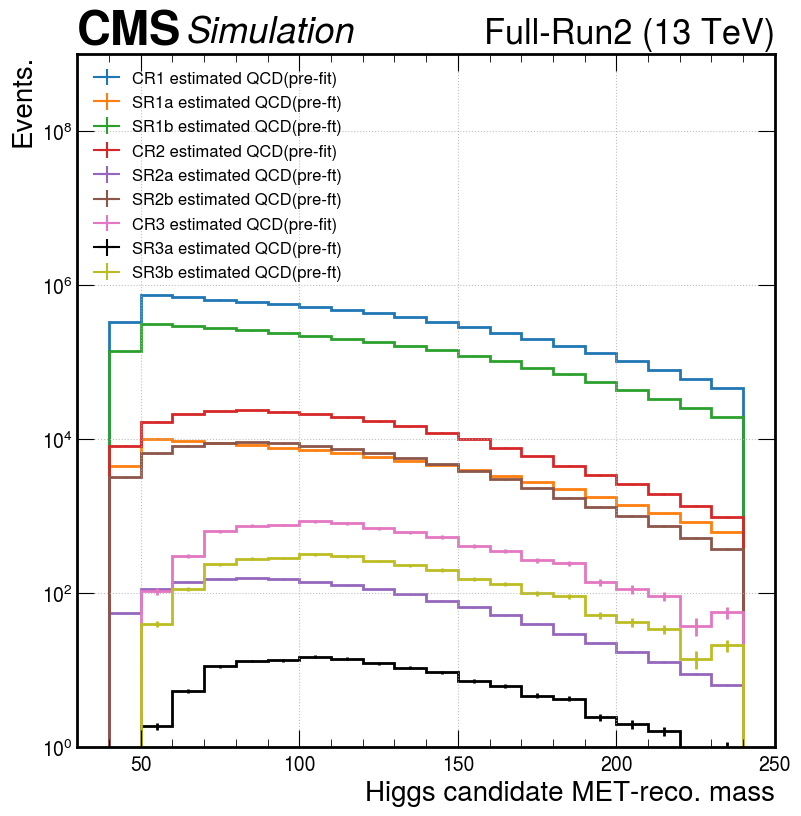

In [9]:
plot_mass_shape_store_blinded(files = files,nbins = 20, x_min=40, x_max=240,suffix = "")

### read the files just stored

In [6]:
def read_root(filename = "/home/pku/zhaoyz/Higgs/MDStudy/SR1a_Shape.root", dir = "QCD", name = "SRa"):
    ''' 
    filename:path/to/root
    dir:"QCD"
    name:region from ["CR1",...]
    '''
    with uproot.open(filename) as file:
        hist = file.get(dir + "/" + name)
        h = np.array(hist.values())
        var = np.array(hist.variances())        
    return h, var
    # here we defined a simple function to read the predicted QCD,etc. shapes from root file directly
    # but you have to be sure with the accuracy about the root file


### Plot variables

In [11]:
from matplotlib.cm import get_cmap
hep.style.use("CMS")
def prefit_plot(arrays, weight, plot_name: str, x_name: str, region = 'PS',othertext = "", year='2018', bins=40, x_min=0, x_max=2000, density=False, overflow=False, underflow=False, fraction_log=False,log = False,blind = False, blindMC = False, nametext = ""):
    LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83,"Full-Run2":138}
    bin_width = (x_max-x_min)/bins
    if blind:
        mask = np.logical_or(arrays["data"] <= 80, arrays["data"] >= 160)
        arrays["data"] = arrays["data"][mask]
        if blindMC:
            maskQCD = np.logical_or(arrays["QCD"] <= 80, arrays["QCD"] >= 160)
            maskTop = np.logical_or(arrays["Top"] <= 80, arrays["Top"] >= 160)
            maskWJets = np.logical_or(arrays["WJets"] <= 80, arrays["WJets"] >= 160)
            maskRest = np.logical_or(arrays["Rest"] <= 80, arrays["Rest"] >= 160)
            maskTotalSignal = np.logical_or(arrays["TotalSignal"] <= 80, arrays["TotalSignal"] >= 160)
            maskggF = np.logical_or(arrays["ggF"] <= 80, arrays["ggF"] >= 160)
            maskVH = np.logical_or(arrays["VH"] <= 80, arrays["VH"] >= 160)
            maskttH = np.logical_or(arrays["ttH"] <= 80, arrays["ttH"] >= 160)
            maskVBF = np.logical_or(arrays["VBF"] <= 80, arrays["VBF"] >= 160)
            
            arrays["QCD"] = arrays["QCD"][maskQCD]
            arrays["Top"] = arrays["Top"][maskTop]
            arrays["WJets"] = arrays["WJets"][maskWJets]
            arrays["Rest"] = arrays["Rest"][maskRest]
            arrays["TotalSignal"] = arrays["TotalSignal"][maskTotalSignal]
            arrays["ggF"] = arrays["ggF"][maskggF]
            arrays["VH"] = arrays["VH"][maskVH]
            arrays["ttH"] = arrays["ttH"][maskttH]
            arrays["VBF"] = arrays["VBF"][maskVBF]
            
            weight["QCD"] = weight["QCD"][maskQCD]
            weight["Top"] = weight["Top"][maskTop]
            weight["WJets"] = weight["WJets"][maskWJets]
            weight["Rest"] = weight["Rest"][maskRest]
            weight["TotalSignal"] = weight["TotalSignal"][maskTotalSignal]
            weight["ggF"] = weight["ggF"][maskggF]
            weight["VH"] = weight["VH"][maskVH]
            weight["ttH"] = weight["ttH"][maskttH]
            weight["VBF"] = weight["VBF"][maskVBF]    
    ## canvas initializing
    f = plt.figure(figsize=(9, 10))
    gs = mpl.gridspec.GridSpec(3, 1, height_ratios=[6, 1, 1], hspace=0.08)
    ax = f.add_subplot(gs[0])
    plt.grid()
    hep.cms.label(loc = 1, data=True, year=year, ax=ax, lumi=LUMI[year], fontsize=18, llabel='Preliminary')
    # Ratio panel
    ax1 = f.add_subplot(gs[1])
    ax2 = f.add_subplot(gs[2])
    ax1.grid()
    ax2.grid()    
    # analyze
    stacked = {'h': {}, 'var': {}} 
    individual = {'h': {}, 'var': {}}
    BKG = ["QCD","Top","WJets","Rest"]
    for (k,v) in arrays.items():
        hist = bh.Histogram(bh.axis.Regular(bins, x_min, x_max), storage=bh.storage.Weight())
        values = ak.fill_none(v, -999)
        if k!='data':
            hist.fill(values, weight=weight[k])
        else:
            hist.fill(values)
        h, var = flow(hist=hist, overflow=overflow, underflow=underflow)
        # here the var are just usual standard variance
        if k in BKG: 
            if k == "QCD":    # read from root  
                stacked['h'][k] , stacked['var'][k]  = read_root(filename = "./root/perfit_QCD.root", dir = "QCD", name = region)
            else:             # other background
                stacked['h'][k] = h
                stacked['var'][k] = var
        else:
            individual['h'][k] = h
            individual['var'][k] = var        
    #plot
    SIG_COLOR={'TotalSignal': 'black',"ggF":"pink","VH":"blue","ttH":"yellow","VBF":"aqua"}
    ax1.plot([x_min,x_max], [1,1], color='black', linestyle='dashed')
    if len(stacked['h'].keys())>0:
        BKG_list = ["Rest","WJets","Top","QCD"]
        err_list = [  np.nan_to_num(error_bar(stacked['h'][k], stacked['var'][k], type = "mc"), nan = 0) for k in BKG_list]
        h_list = [stacked['h'][k] for k in BKG_list]
        label_list = BKG_list
        colors = ["#1f77b4", "#ff7f0e", "#2ca02c","#d62728"]
        hep.histplot(h_list, bins=hist.axes[0].edges, label=label_list, yerr = err_list, histtype='fill', density=density, stack=True, linewidth=2, ax=ax,color = colors)
        bkg_h = np.sum(list(stacked['h'].values()), axis=0)
        bkg_err = np.sum(err_list ,  axis=0)
        bin_edges = np.linspace(x_min, x_max, bins+1)
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
        ax.errorbar(x = bin_centers,y = bkg_h, yerr=bkg_err, fmt='none', color='gray', capsize=2,markersize = 3)
    # Scale the signal according to total BKG to make it visiable:
    NORM_s1=np.sum(bkg_h)/(np.sum(individual["h"]["TotalSignal"])+0.000001);
    print("Should scale signal * ",NORM_s1)
    if                       NORM_s1>=300000: NORM_s1=300000
    elif  300000>NORM_s1 and NORM_s1>=100000: NORM_s1= 100000
    elif  100000>NORM_s1 and NORM_s1>= 30000: NORM_s1= 30000
    elif   30000>NORM_s1 and NORM_s1>= 10000: NORM_s1=  10000
    elif   10000>NORM_s1 and NORM_s1>=  3000: NORM_s1=  3000
    elif    3000>NORM_s1 and NORM_s1>=  1000: NORM_s1=   1000
    elif    1000>NORM_s1 and NORM_s1>=   300: NORM_s1=   300
    elif     300>NORM_s1 and NORM_s1>=   100: NORM_s1=    100
    elif     100>NORM_s1 and NORM_s1>=    30: NORM_s1=    30
    elif      30>NORM_s1 and NORM_s1>=    10: NORM_s1=     10
    else                                    : NORM_s1=     1   
    for (k,h) in individual['h'].items():
        if k=='data': #data
            err = error_bar(h, individual['var'][k], type='data')
            hep.histplot(h, bins=hist.axes[0].edges, yerr=err, label=k, color='black', histtype='errorbar', density=density, stack=False, ax=ax)
            ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
            hep.histplot(h/bkg_h, bins=hist.axes[0].edges, yerr=ratio_error, color='black', histtype='errorbar', density=density, stack=False, ax=ax1)    
            data_mc_ratio = np.sum(h)/np.sum(bkg_h)
        else:  # signal
            err = error_bar(h, individual['var'][k], type='mc')
            hep.histplot(h*NORM_s1, bins=hist.axes[0].edges, yerr=NORM_s1*err, label=k+r"$\times$"+str(NORM_s1), histtype='step', density=density, stack=False, linewidth=2, ax=ax, color=SIG_COLOR[k])
            y = h / np.sqrt(bkg_h + 1)
            hep.histplot(y, bins=hist.axes[0].edges, yerr=err/np.sqrt(bkg_h+1), label=k, histtype='step', density=density, stack=False, ax=ax2, color=SIG_COLOR[k])
            if k == "TotalSignal":
                best_lower, best_upper, best_s_sqrt_b = optimalcut(h,bkg_h)
                print("Optimal cut =",best_lower, best_upper, best_s_sqrt_b) # todo
    ax.set_xlim(x_min, x_max)
    if log:
        ax.set_ylim(0.01 if not density else 0, ax.get_ylim()[1]*(1e3 if not density else 1.2))
    else:
        ax.set_ylim(0.01 if not density else 0, ax.get_ylim()[1]*1.3)
    # if not density:
    #     ax.set_yscale('log')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', which='major', labelsize=0)
    if density==False:
        ax.set_ylabel('Events', fontsize=20, ha='right', y=1)
    elif density==True:    
        ax.set_ylabel('A.U.', fontsize=20, ha='right', y=1)
    ax1.set_xlim(x_min, x_max)
    ax1.set_xticklabels([])
    if fraction_log:
        ax1.set_ylim(1e-1, 1e1)
        ax1.set_yscale('log')
    else:
        ax1.set_ylim(0, 2)
    ax1.set_ylabel(r'$\frac{Data}{bkg\ MC}$', ha='center', fontsize=24)
    ax1.tick_params(axis='both', which='major', labelsize=16)
    ax2.set_xlim(x_min, x_max)
    ax2.set_ylim(0, ax2.get_ylim()[1]*1.2)
    ax2.tick_params(axis='both', which='major', labelsize=16)
    ax2.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    ax2.set_ylabel(r'$S/\sqrt{B+1}$', ha='center', fontsize=16)
    ax2.ticklabel_format(useOffset=False, style='plain')
    ax2.tick_params(axis='both', which='major', labelsize=16)
    plt.xticks(size=14)
    plt.yticks(size=14)
    if blind:
        plt.text(0.05,0.83,region + " " + othertext + " blinded",fontsize=17, color="black", ha='left',transform=ax.transAxes)
    else:
        plt.text(0.05,0.83,region + othertext + " Data/MC = " + str(round(data_mc_ratio,3)),fontsize=17, color="black", ha='left',transform=ax.transAxes)        
    ax.legend(loc="upper right", ncol=2, frameon=False, fontsize=13)
    suffix = '_AU' if density else ''
    if not os.path.exists('./plots'):
        os.makedirs('./plots')
    plt.savefig(f"./plots/{year}_{plot_name}{suffix}_{region}{othertext}_{nametext}.pdf", bbox_inches='tight')
    plt.show()

In [13]:
CUT = {        
        "SR1a" : {k: ( (files[k]["a_HWW_V2"] > 0.975) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] < 0.3)) for k in files},
        "SR1b" : {k: ( (files[k]["a_HWW_V2"] > 0.8) & (files[k]["a_HWW_V2"] <= 0.975) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] < 0.3)) for k in files}, 
        "SR2a" : {k: ( (files[k]["DPhi"] < 0.8)     & (files[k]["a_HWW_V2"] > 0.975)  & (files[k]["MET_et"]/files[k]["PTj_V2_a"] >= 0.3) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] < 0.6)) for k in files},
        "SR2b" : {k: ( (files[k]["a_HWW_V2"] > 0.8) & (files[k]["a_HWW_V2"] <= 0.975) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] >= 0.3) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] < 0.6)) for k in files},
        "SR3a" : {k: ( (files[k]["DPhi"] < 0.8) & (files[k]["a_HWW_V2"] > 0.975) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] >= 0.6)) for k in files},
        "SR3b" : {k: ( (files[k]["DPhi"] < 0.8) & (files[k]["a_HWW_V2"] <= 0.975) & (files[k]["a_HWW_V2"] > 0.8) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] >= 0.6)) for k in files},
        "CR1"  : {k: ( (files[k]["a_HWW_V2"] > 0.6) & (files[k]["a_HWW_V2"] <= 0.8) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] < 0.3)) for k in files}, 
        "CR2"  : {k: ( (files[k]["a_HWW_V2"] > 0.6) & (files[k]["a_HWW_V2"] <= 0.8) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] >= 0.3) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] < 0.6)) for k in files},       
        "CR3"  : {k: ( (files[k]["DPhi"] < 0.8) & (files[k]["a_HWW_V2"] <= 0.8) & (files[k]["a_HWW_V2"] > 0.6) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] >= 0.6)) for k in files},
    }

# CR: 0.6-0.8

In [ ]:
CUT_BLINDED = {
        "SR1a_blinded" : {k: ( ((files[k]["MH_Reco"] <= 80) | (files[k]["MH_Reco"] >= 160)) & (files[k]["a_HWW_V2"] > 0.975) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] < 0.3)) for k in files},
        "SR1b_blinded" : {k: ( ((files[k]["MH_Reco"] <= 80) | (files[k]["MH_Reco"] >= 160)) & (files[k]["a_HWW_V2"] > 0.8) & (files[k]["a_HWW_V2"] <= 0.975) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] < 0.3)) for k in files}, 
        "SR2a_blinded" : {k: ( ((files[k]["MH_Reco"] <= 80) | (files[k]["MH_Reco"] >= 160)) & (files[k]["DPhi"] < 0.8)     & (files[k]["a_HWW_V2"] > 0.975)  & (files[k]["MET_et"]/files[k]["PTj_V2_a"] >= 0.3) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] < 0.6)) for k in files},
        "SR2b_blinded" : {k: ( ((files[k]["MH_Reco"] <= 80) | (files[k]["MH_Reco"] >= 160)) & (files[k]["a_HWW_V2"] > 0.8) & (files[k]["a_HWW_V2"] <= 0.975) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] >= 0.3) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] < 0.6)) for k in files},
        "SR3a_blinded" : {k: ( ((files[k]["MH_Reco"] <= 80) | (files[k]["MH_Reco"] >= 160)) & (files[k]["DPhi"] < 0.8) & (files[k]["a_HWW_V2"] > 0.975) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] >= 0.6)) for k in files},
        "SR3b_blinded" : {k: ( ((files[k]["MH_Reco"] <= 80) | (files[k]["MH_Reco"] >= 160)) & (files[k]["DPhi"] < 0.8) & (files[k]["a_HWW_V2"] <= 0.975) & (files[k]["a_HWW_V2"] > 0.8) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] >= 0.6)) for k in files},
        "CR1_blinded"  : {k: ( ((files[k]["MH_Reco"] <= 80) | (files[k]["MH_Reco"] >= 160)) & (files[k]["a_HWW_V2"] > 0.6) & (files[k]["a_HWW_V2"] <= 0.8) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] < 0.3)) for k in files}, 
        "CR2_blinded"  : {k: ( ((files[k]["MH_Reco"] <= 80) | (files[k]["MH_Reco"] >= 160)) & (files[k]["a_HWW_V2"] > 0.6) & (files[k]["a_HWW_V2"] <= 0.8) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] >= 0.3) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] < 0.6)) for k in files},       
        "CR3_blinded"  : {k: ( ((files[k]["MH_Reco"] <= 80) | (files[k]["MH_Reco"] >= 160)) & (files[k]["DPhi"] < 0.8) & (files[k]["a_HWW_V2"] <= 0.8) & (files[k]["a_HWW_V2"] > 0.6) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] >= 0.6)) for k in files},
}

In [15]:
def prefit_runPlots(region = "PS", events = files,othertext = "", blind = True):
    weight={k: events[k][CUT[region][k]]["weight"] for k in events}   
    prefit_plot(arrays = {k: events[k][CUT[region][k]]["MH_Reco"] for k in events},  region = region, othertext = othertext, plot_name='METReco', x_name=r'$jet_{a}:MET Reco. Mass$', x_max=240, x_min=40, bins=20, weight =weight, year="Full-Run2",blind = blind, blindMC = False)

Should scale signal *  1159.1320761952727
Optimal cut = 6 11 0.32611438062239645


/tmp/ipykernel_2498319/195236659.py:105: RuntimeWarning: invalid value encountered in divide
  ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
/tmp/ipykernel_2498319/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_2498319/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_2498319/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h


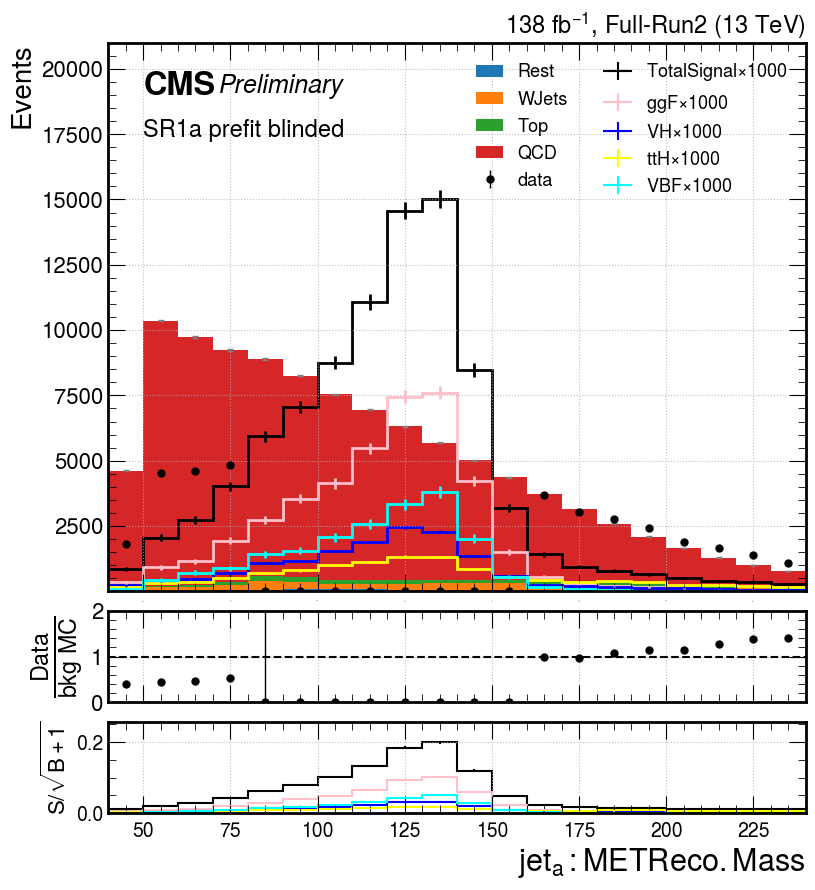

Should scale signal *  11504.292108803664
Optimal cut = 6 12 0.17343983574615968


/tmp/ipykernel_2498319/195236659.py:105: RuntimeWarning: invalid value encountered in divide
  ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
/tmp/ipykernel_2498319/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_2498319/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_2498319/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h


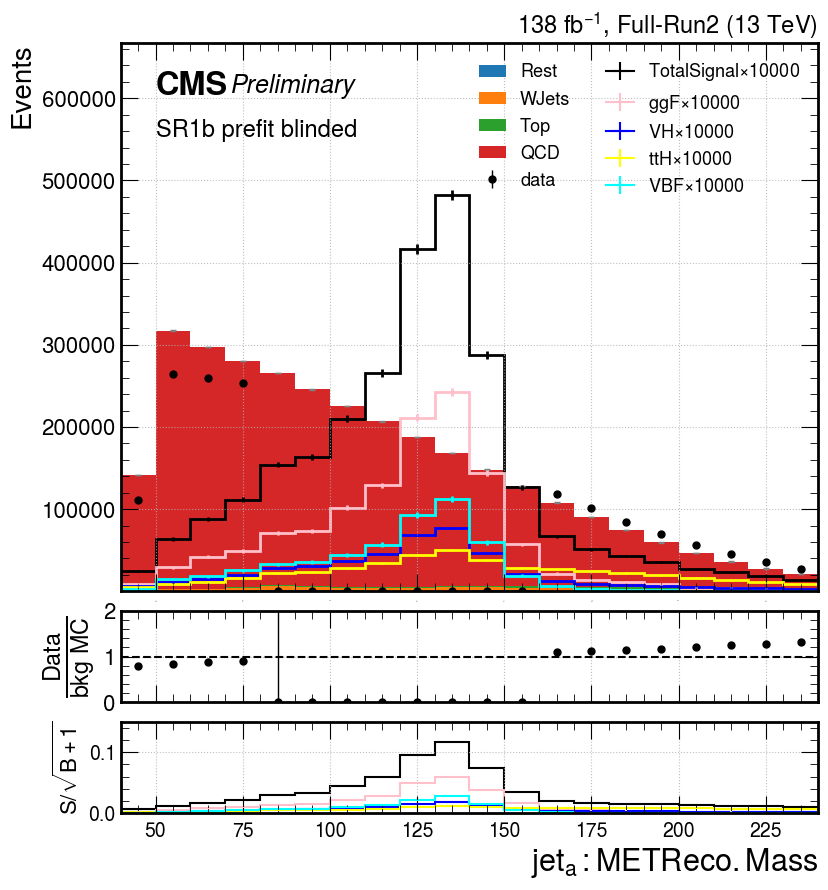

Should scale signal *  38203.42257174624
Optimal cut = 4 20 0.07373290878321552


/tmp/ipykernel_2498319/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_2498319/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_2498319/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h


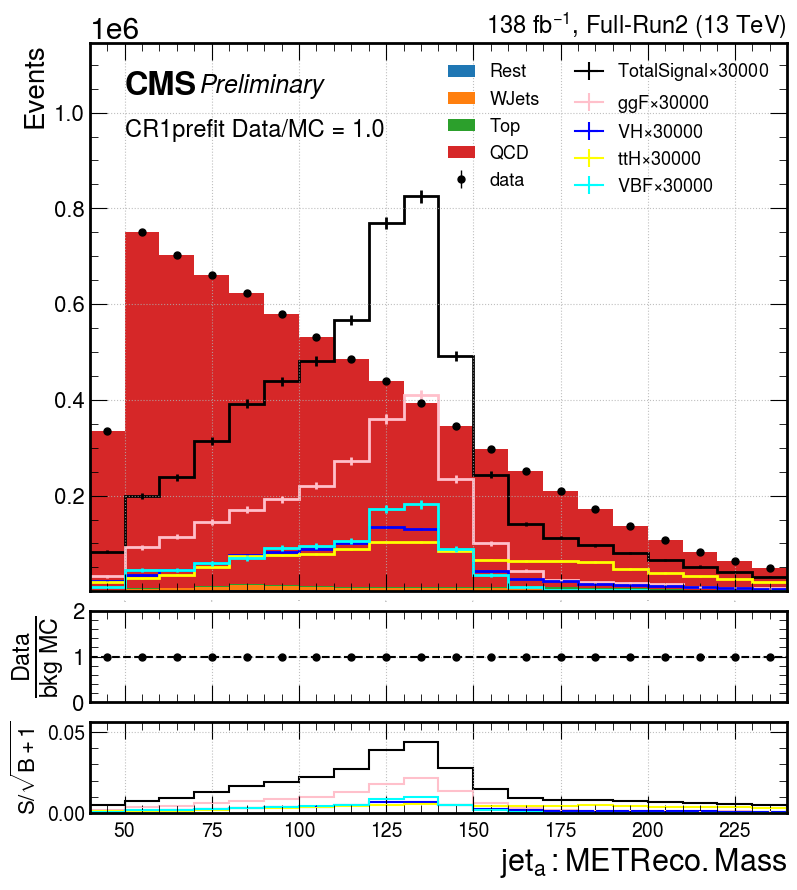

/tmp/ipykernel_2498319/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_2498319/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_2498319/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_2498319/195236659.py:105: RuntimeWarning: invalid value encountered in divide
  ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
/tmp/ipykernel_2498319/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_2498319/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_2498319/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_2498319/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_2498

Should scale signal *  139.92142275220212
Optimal cut = 4 14 0.36457216880367194


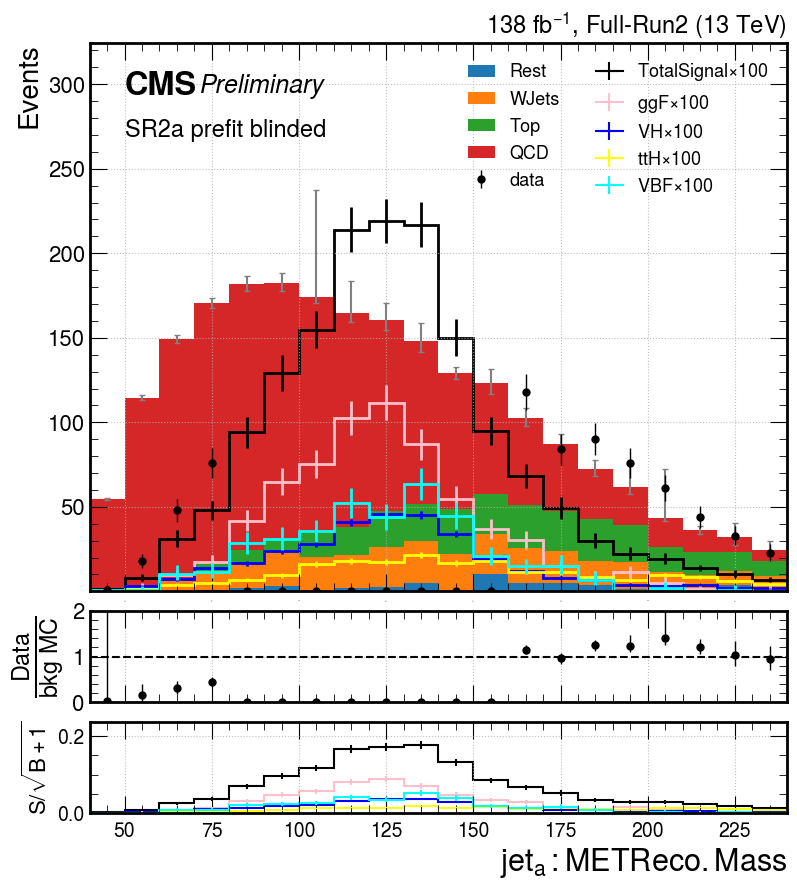

Should scale signal *  3444.987640623713
Optimal cut = 5 20 0.09818601144672219


/tmp/ipykernel_2498319/195236659.py:105: RuntimeWarning: invalid value encountered in divide
  ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
/tmp/ipykernel_2498319/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_2498319/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_2498319/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h


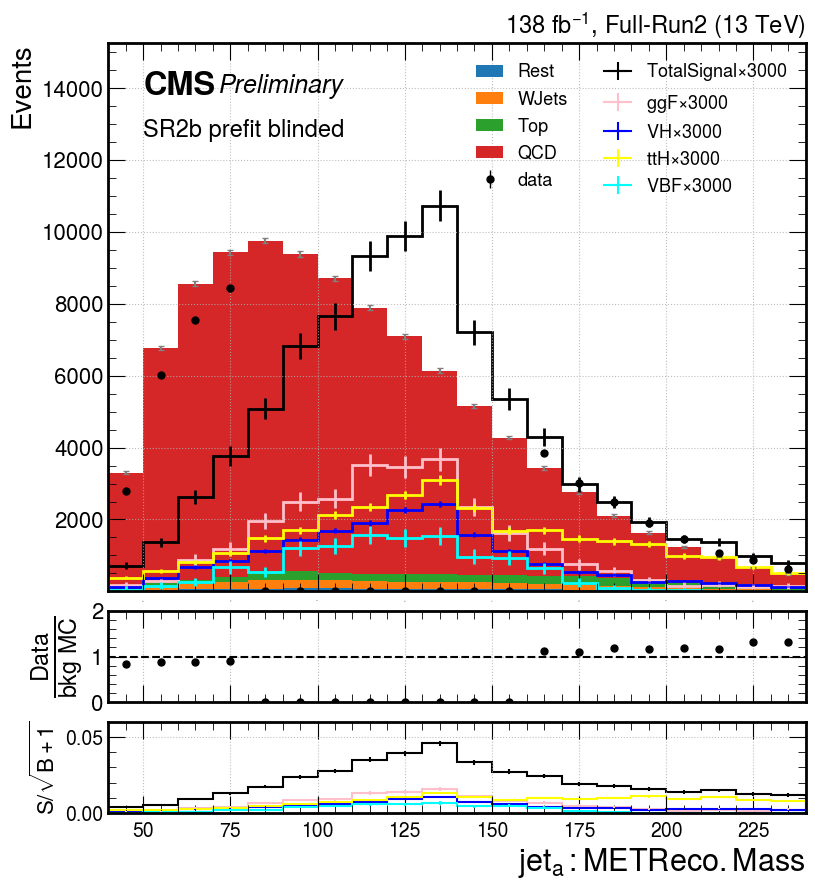

Should scale signal *  12586.398484075913
Optimal cut = 4 20 0.04116018318483422


/tmp/ipykernel_2498319/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_2498319/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_2498319/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h


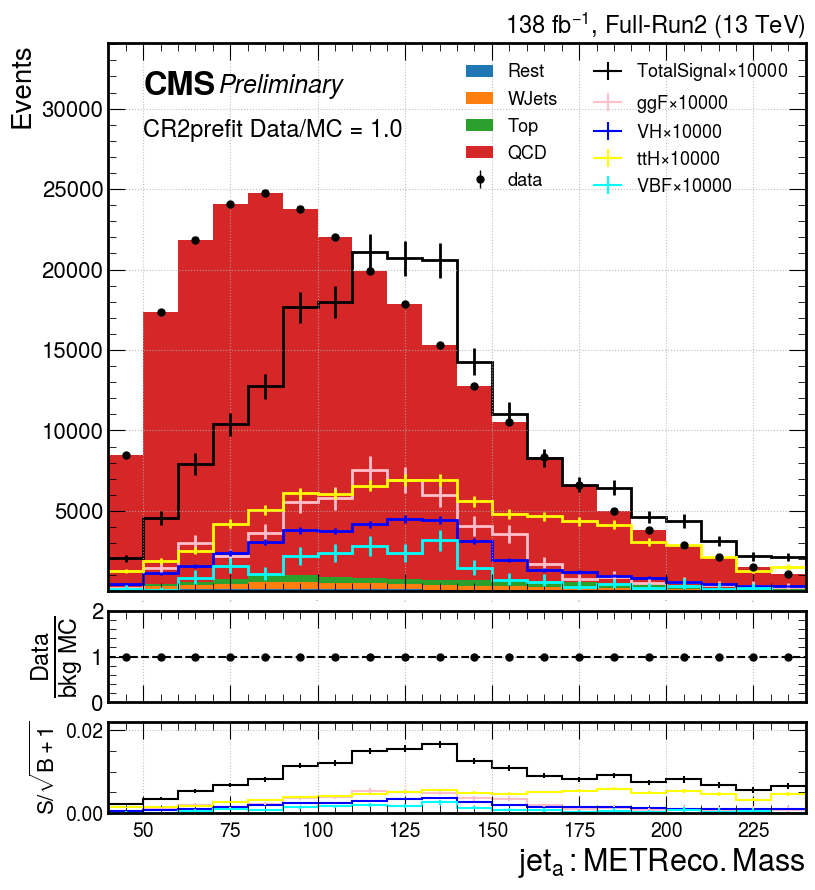

/tmp/ipykernel_2498319/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_2498319/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_2498319/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_2498319/195236659.py:105: RuntimeWarning: invalid value encountered in divide
  ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
/tmp/ipykernel_2498319/195236659.py:106: RuntimeWarning: invalid value encountered in divide
  hep.histplot(h/bkg_h, bins=hist.axes[0].edges, yerr=ratio_error, color='black', histtype='errorbar', density=density, stack=False, ax=ax1)
/tmp/ipykernel_2498319/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_2498319/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_2498

Should scale signal *  57.005247022467735
Optimal cut = 1 11 0.48977547450865816


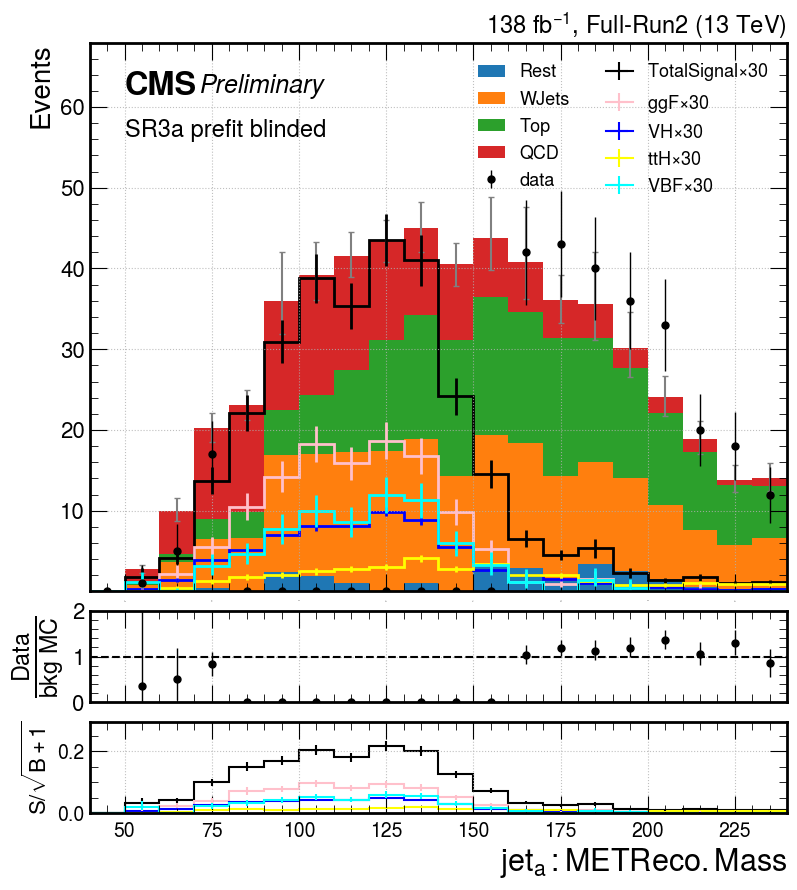

/tmp/ipykernel_2498319/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_2498319/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_2498319/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_2498319/195236659.py:105: RuntimeWarning: invalid value encountered in divide
  ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
/tmp/ipykernel_2498319/195236659.py:106: RuntimeWarning: invalid value encountered in divide
  hep.histplot(h/bkg_h, bins=hist.axes[0].edges, yerr=ratio_error, color='black', histtype='errorbar', density=density, stack=False, ax=ax1)
/tmp/ipykernel_2498319/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_2498319/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_2498

Should scale signal *  385.9296435638134
Optimal cut = 2 20 0.17618772593707765


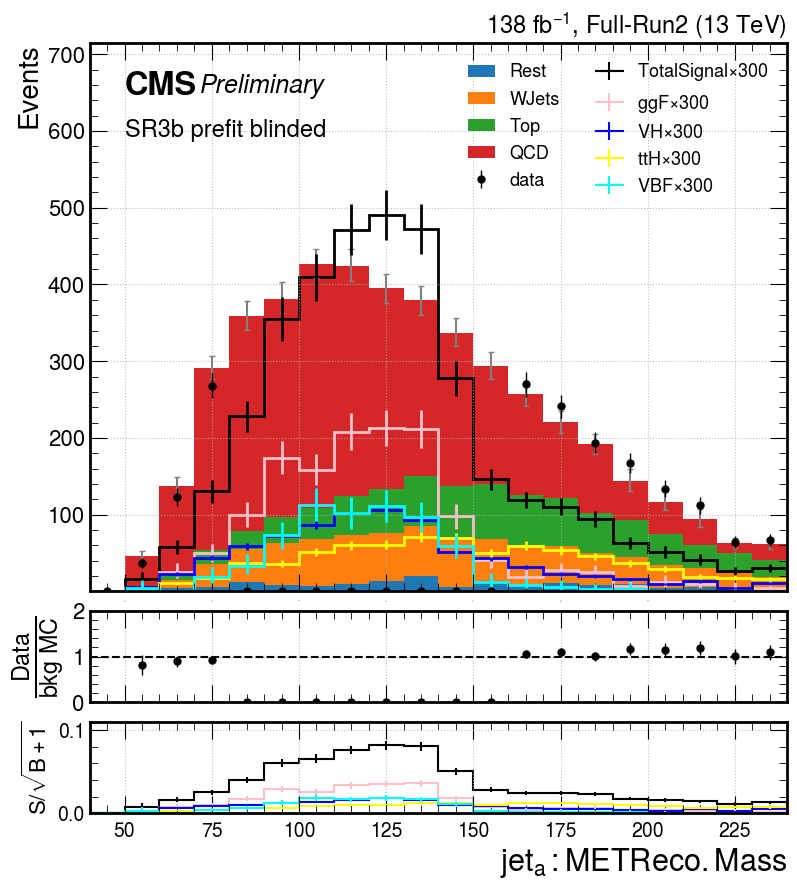

/tmp/ipykernel_2498319/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_2498319/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_2498319/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_2498319/195236659.py:105: RuntimeWarning: invalid value encountered in divide
  ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
/tmp/ipykernel_2498319/195236659.py:106: RuntimeWarning: invalid value encountered in divide
  hep.histplot(h/bkg_h, bins=hist.axes[0].edges, yerr=ratio_error, color='black', histtype='errorbar', density=density, stack=False, ax=ax1)
/tmp/ipykernel_2498319/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_2498319/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_2498

Should scale signal *  1569.3417080975908
Optimal cut = 3 20 0.0625589540005484


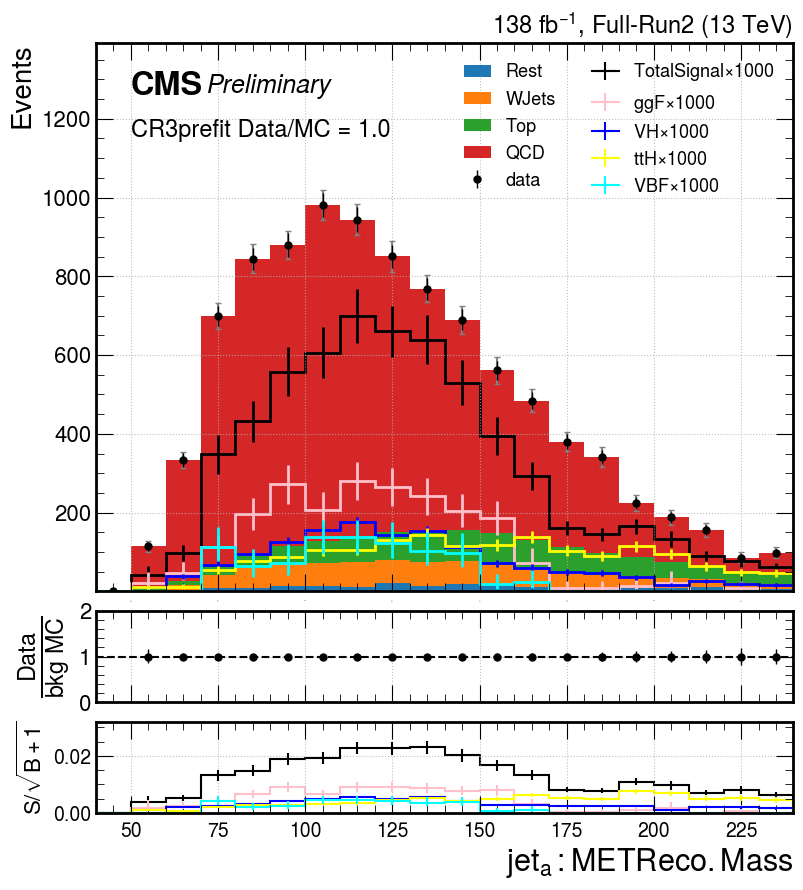

In [16]:
prefit_runPlots(region = "SR1a", othertext = "prefit")
prefit_runPlots(region = "SR1b", othertext = "prefit")
prefit_runPlots(region = "CR1",  othertext = "prefit", blind = False)
prefit_runPlots(region = "SR2a", othertext = "prefit")
prefit_runPlots(region = "SR2b", othertext = "prefit")
prefit_runPlots(region = "CR2",  othertext = "prefit", blind = False)
prefit_runPlots(region = "SR3a", othertext = "prefit")
prefit_runPlots(region = "SR3b", othertext = "prefit")
prefit_runPlots(region = "CR3",  othertext = "prefit", blind = False)

### Define observable object variables

In [8]:
@dataclass
class ShapeVar:
    """Class to store attributes of a variable to make a histogram of.

    Args:
        var (str): variable name
        label (str): variable label
        bins (List[int]): bins
        reg (bool, optional): Use a regular axis or variable binning. Defaults to True.
        blind_window (List[int], optional): if blinding, set min and max values to set 0. Defaults to None.
        significance_dir (str, optional): if plotting significance, which direction to plot it in.
          See more in plotting.py:ratioHistPlot(). Options are ["left", "right", "bin"]. Defaults to "right".
    """

    var: str = None
    label: str = None
    bins: List[int] = None
    reg: bool = True #regular axis
    blind_window: List[int] = None
    significance_dir: str = "right"

    def __post_init__(self):
        # create axis used for histogramming
        if self.reg:
            self.axis = hist2.axis.Regular(*self.bins, name=self.var, label=self.label)
        else:
            self.axis = hist2.axis.Variable(self.bins, name=self.var, label=self.label)
def blindBins(h: hist2.Hist, blind_region: List, blind_sample: str = None, axis=0):
    """
    Blind (i.e. zero) bins in histogram ``h``.
    If ``blind_sample`` specified, only blind that sample, else blinds all.
    """
    if axis > 0:
        raise Exception("not implemented > 1D blinding yet")

    bins = h.axes[axis + 1].edges
    lv = int(np.searchsorted(bins, blind_region[0], "right"))
    rv = int(np.searchsorted(bins, blind_region[1], "left") + 1)

    if blind_sample is not None:
        data_key_index = np.where(np.array(list(h.axes[0])) == blind_sample)[0][0]
        h.view(flow=True)[data_key_index][lv:rv].value = 0
        h.view(flow=True)[data_key_index][lv:rv].variance = 0
    else:
        h.view(flow=True)[:, lv:rv].value = 0
        h.view(flow=True)[:, lv:rv].variance = 0       
shape_vars = [
    ShapeVar(
        "MH_Reco",
        r"Higgs candidate MET recovery mass [GeV]",
        [20, 40, 240],
        reg=True,
        blind_window=[80, 160],
    )
]


### Save hist templates to pkl files

In [26]:

def save_pkl(files, template_file = "./templates/hists_templates_run2.pkl"):
    regions = ["SR1a","SR1b","CR1","SR2a","SR2b","CR2","SR3a","SR3b","CR3"] #signal regions or control regions
    # regions = ["SR1a","SR1b","CR1a","CR1b","SR2a","SR2b","CR2a","CR2b","SR3a","SR3b","CR3a","CR3b"]
    # samples = list(['data','QCD','Top','WJets','Rest','TotalSignal','ggF','VH','ttH','VBF']) 
    samples = list(['data','QCD','Top','WJets','Rest','ggF','VH','ttH','VBF']) # ignore the combined "TotalSignal" for a test
    weights = [] #uncertainties to be added 
    templates = {}
    for region in regions:
        templates[region] = hist2.Hist(
            hist2.axis.StrCategory(samples, name="Sample"),
            # hist2.axis.StrCategory([], name="systematic", growth=True),
            *[shape_var.axis for shape_var in shape_vars],
            storage="weight",
            ) #initialize a hist object
        for sample in samples:
            data = files[sample][CUT[region][sample]] if ("blinded" not in region) else files[sample][CUT_BLINDED[region][sample]]
            templates[region].fill(
                Sample=sample,
                # systematic="nominal",
                MH_Reco=data["MH_Reco"],
                weight=data["weight"],
            )
            if sample == "data": 
                if (region.endswith("a") or region.endswith("b")):
                    # blind signal mass windows in pass region in data
                    print("blind data of ",region)
                    for i, shape_var in enumerate(shape_vars):
                        if shape_var.blind_window is not None:
                            blindBins(templates[region], shape_var.blind_window, "data", axis=i) 
            for weight in weights:
                pass #uncertainties to be added
        print("done fill template ",region)        
    #Creates blinded copies of each region's templates and saves a pickle of the templates
    blind_window = shape_vars[0].blind_window
    for label, template in list(templates.items()):
        blinded_template = deepcopy(template)
        blindBins(blinded_template, blind_window)
        templates[f"{label}Blinded"] = blinded_template
    with open(template_file, "wb") as fp:
        pkl.dump(templates, fp) # dump the templates of each region in a pkl file
        print("Saved templates to", template_file)

In [8]:
save_pkl(files = files)


blind data of  SR1a
done fill template  SR1a
blind data of  SR1b
done fill template  SR1b
done fill template  CR1
blind data of  SR2a
done fill template  SR2a
blind data of  SR2b
done fill template  SR2b
done fill template  CR2
blind data of  SR3a
done fill template  SR3a
blind data of  SR3b
done fill template  SR3b
done fill template  CR3
Saved templates to ./templates/hists_templates_run2_newCR.pkl


### some test about the output templates

In [27]:
with open("/ospool/cms-user/yuzhe/BoostedHWW/prediction/HHbbVV/src/HHbbVV/postprocessing/templates/23May13Nonres/2017_templates.pkl","rb") as f:
    hists_template = pkl.load(f)
# hists_template["pass"]["QCD",:]  
# hists_template["pass"]["QCD",:].sum().value
hists_template["pass"]["QCD",:]

Hist(Regular(20, 50, 250, name='bbFatJetParticleNetMass', label='$m^{bb}_{Reg}$ (GeV)'), storage=Weight()) # Sum: WeightedSum(value=39.3871, variance=137.026)

In [17]:
with open("/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedHWW/combine/templates/hists_templates_run2.pkl","rb") as f:
    hists_template = pkl.load(f)
# hists_template["pass"]["QCD",:]  
# hists_template["pass"]["QCD",:].sum().value
# hists_template["CR2"]["QCD",:]
hists_template["SR3b"]["Top",:]

Hist(Regular(20, 40, 240, name='MH_Reco', label='Higgs candidate MET recovery mass [GeV]'), storage=Weight()) # Sum: WeightedSum(value=778.591, variance=53.3967) (WeightedSum(value=876.87, variance=60.5062) with flow)

In [18]:
hists_template["passBlinded"]

Hist(
  StrCategory(['HHbbVV', 'QCD', 'TT', 'ST', 'V+Jets', 'Diboson', 'Data', 'HHbbVV_txbb_down', 'HHbbVV_pileup_down', 'QCD_pileup_down', 'TT_pileup_down', 'ST_pileup_down', 'V+Jets_pileup_down', 'Diboson_pileup_down', 'HHbbVV_PDFalphaS_down', 'HHbbVV_ISRPartonShower_down', 'V+Jets_ISRPartonShower_down', 'HHbbVV_FSRPartonShower_down', 'V+Jets_FSRPartonShower_down', 'HHbbVV_L1EcalPrefiring_down', 'QCD_L1EcalPrefiring_down', 'TT_L1EcalPrefiring_down', 'ST_L1EcalPrefiring_down', 'V+Jets_L1EcalPrefiring_down', 'Diboson_L1EcalPrefiring_down', 'HHbbVV_txbb_up', 'HHbbVV_pileup_up', 'QCD_pileup_up', 'TT_pileup_up', 'ST_pileup_up', 'V+Jets_pileup_up', 'Diboson_pileup_up', 'HHbbVV_PDFalphaS_up', 'HHbbVV_ISRPartonShower_up', 'V+Jets_ISRPartonShower_up', 'HHbbVV_FSRPartonShower_up', 'V+Jets_FSRPartonShower_up', 'HHbbVV_L1EcalPrefiring_up', 'QCD_L1EcalPrefiring_up', 'TT_L1EcalPrefiring_up', 'ST_L1EcalPrefiring_up', 'V+Jets_L1EcalPrefiring_up', 'Diboson_L1EcalPrefiring_up'], name='Sample'),
  Regular(20, 50, 250, name='bbFatJetParticleNetMass', label='$m^{bb}_{Reg}$ (GeV)'),
  storage=Weight()) # Sum: WeightedSum(value=461.893, variance=1092.32)

In [19]:
sample_template = hists_template["pass"]["QCD", :]
err = sample_template.variances()
err

array([13.28524337,  1.63602478, 35.13665137, 24.8476674 , 17.38421633,
        0.23765398,  0.        ,  0.        ,  0.        , 14.19115751,
       12.12285395,  0.        ,  0.        , 18.0306419 ,  0.        ,
        0.        ,  0.        ,  0.15379214,  0.        ,  0.        ])

In [5]:
for i , axis in enumerate(hists_template["pass"].axes[1:]):
    print(i, axis)

0 Regular(20, 50, 250, name='bbFatJetParticleNetMass', label='$m^{bb}_{Reg}$ (GeV)')


In [13]:
with open("./templates/hists_templates_non_blinded.pkl", "rb") as f:
    hists_templates3 = pkl.load(f)
# hists_templates2["SR2b"]["QCD","nominal",:]
# hists_templates3["SR2a"]["WJets",:].variances()
# hists_templates3["SR2a"]["WJets",:].values(flow=True)
# hists[region][sample,:].variances()
# hists_templates3["SR3a"]["QCD",:].sum().value
# hists_templates3["SR3a_blinded"].axes[1:].edges
hists_templates3["SR1a"]["data",:]


Hist(Regular(20, 40, 240, name='MH_Reco', label='Higgs candidate MET recovery mass [GeV]'), storage=Weight()) # Sum: WeightedSum(value=33745, variance=33745) (WeightedSum(value=37202, variance=37202) with flow)

In [18]:
def get_template(h, sample):
    ''' 
    histogram h Hist, with axes:["samples","systematic","MH_Reco"]
    sample is sample name in ["QCD",...,"data"]
    '''
    mass_axis = 1 #axis index
    massbins = h.axes[mass_axis].edges
    return (h[sample, :].values(), massbins, "MH_Reco")
a = get_template(hists_templates3["SR3a"],"QCD")
a

(array([ 0.        ,  2.61734887,  2.40244829, 13.38662184,  0.        ,
        12.94938391,  7.15780488, 11.0105996 , 18.07070539,  0.        ,
         7.82469779,  0.89133593,  1.93871653,  2.80038463,  3.449436  ,
         0.53863144,  0.2711149 ,  0.3287236 ,  0.        ,  2.0529086 ]),
 array([ 40.,  50.,  60.,  70.,  80.,  90., 100., 110., 120., 130., 140.,
        150., 160., 170., 180., 190., 200., 210., 220., 230., 240.]),
 'MH_Reco')

In [11]:
print(np.linspace(40, 240, 21))

[ 40.  50.  60.  70.  80.  90. 100. 110. 120. 130. 140. 150. 160. 170.
 180. 190. 200. 210. 220. 230. 240.]


In [22]:
region = "SR1a_blinded"
region_noblinded = region.split("Blinded")[0]
region_noblinded

'SR1a_blinded'

In [23]:
with open("/ospool/cms-user/yuzhe/BoostedHWW/templates/hists_templates.pkl", "rb") as f:
    hists_templates2 = pkl.load(f)
# hists_templates2["SR2b"]["QCD","nominal",:]
hists_templates2["SR1a"]


Hist(
  StrCategory(['data', 'QCD', 'Top', 'WJets', 'Rest', 'TotalSignal', 'ggF', 'VH', 'ttH', 'VBF'], growth=True, name='samples'),
  StrCategory(['nominal'], growth=True, name='systematic'),
  Variable([40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240], name='MH_Reco', label='Higgs candidate MET recovery mass [GeV]'),
  storage=Double()) # Sum: 180718.16633693522 (187720.00093823727 with flow)

In [24]:
s = hists_templates2["SR2b"]["QCD","nominal",:].values()
s

array([3203.02070336, 6572.62066135, 8285.4921792 , 9054.65869084,
       9238.41630798, 8848.39851649, 8216.47968383, 7426.8752504 ,
       6636.35788367, 5675.92702307, 4705.99830901, 3851.05757845,
       3016.61454661, 2346.25346119, 1746.21552669, 1329.19273989,
       1006.60297794,  747.02345128,  521.59205541, 1340.4213692 ])

In [25]:
s = hists_templates2["SR2b"]["WJets","nominal",:].variances()
s

In [26]:
s = hists_templates2["SR2b"]["QCD","nominal",:].values()
values_nominal = np.maximum(s, 0.0)
values_nominal

array([3203.02070336, 6572.62066135, 8285.4921792 , 9054.65869084,
       9238.41630798, 8848.39851649, 8216.47968383, 7426.8752504 ,
       6636.35788367, 5675.92702307, 4705.99830901, 3851.05757845,
       3016.61454661, 2346.25346119, 1746.21552669, 1329.19273989,
       1006.60297794,  747.02345128,  521.59205541, 1340.4213692 ])

In [28]:
# values_nominal = np.maximum(s.values(), 0.0)
# values_nominal

In [29]:
for i, axis in enumerate(hists_templates2["SR1a"].axes[2:]):
    print(i, axis) 

0 Variable([40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240], name='MH_Reco', label='Higgs candidate MET recovery mass [GeV]')


In [ ]:
region = "SR1a"
region2 = "CR1"
pass_region = (region.endswith("a") or region.endswith("b"))
pass_region

True

In [ ]:
hists_templates["SR3a"].project("MH_Reco") #N.B. here data is also added

Hist(Variable([40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240], name='MH_Reco', label='Higgs candidate MET recovery mass [GeV]'), storage=Double()) # Sum: 1284.0328060902589 (1391.2353290328374 with flow)

In [ ]:
hists_templates["SR3a"].axes[2].edges #access the axes through index

array([ 40.,  50.,  60.,  70.,  80.,  90., 100., 110., 120., 130., 140.,
       150., 160., 170., 180., 190., 200., 210., 220., 230., 240.])

In [ ]:
massbins = hists_templates["SR1a"].axes[2].edges
masses = (massbins[:-1] + 0.5 * np.diff(massbins))
mass_scaled = (masses - masses[0]) / (masses[-1] - masses[0])
mass_scaled

array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
       0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ])

In [ ]:
hists_templates["SR3a"][{"samples": "QCD", "systematic": "nominal"}].values() #another way to access the value

array([ 0.        ,  1.85686087,  5.33073188, 11.09815239, 13.09203295,
       13.29814235, 14.8429755 , 14.00588169, 12.18572567, 10.69694686,
        9.2954443 ,  7.19961509,  6.13408838,  4.63281281,  4.22245801,
        2.41129675,  1.95302421,  1.59153709,  0.65292898,  2.98913682])

In [ ]:
with open("/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedhiggs/combine/templates/v1/hists_templates_2017_ele.pkl", "rb") as f:
    hists_templates2 = pkl.load(f)
# hists_templates2["SR2b"]["QCD","nominal",:]
hists_templates2

{'pass': Hist(
   StrCategory(['WJetsLNu', 'DYJets', 'VBF', 'VH', 'TTbar', 'SingleTop', 'ggF', 'WZQQ', 'Data', 'QCD', 'Diboson', 'ttH'], growth=True, name='samples'),
   StrCategory(['nominal', 'weight_ele_pileupUp', 'weight_ele_pileupDown', 'weight_ele_isolation_electronUp', 'weight_ele_isolation_electronDown', 'weight_ele_id_electronUp', 'weight_ele_id_electronDown', 'weight_ele_L1PrefiringUp', 'weight_ele_L1PrefiringDown', 'weight_ele_trigger_electronUp', 'weight_ele_trigger_electronDown', 'weight_ele_reco_electronUp', 'weight_ele_reco_electronDown', 'weight_ele_aS_weightUp', 'weight_ele_aS_weightDown', 'weight_ele_UEPS_FSRUp', 'weight_ele_UEPS_FSRDown', 'weight_ele_UEPS_ISRUp', 'weight_ele_UEPS_ISRDown', 'weight_ele_PDF_weightUp', 'weight_ele_PDF_weightDown', 'weight_ele_PDFaS_weightUp', 'weight_ele_PDFaS_weightDown', 'weight_ele_scalevar_3ptUp', 'weight_ele_scalevar_3ptDown', 'weight_ele_scalevar_7ptUp', 'weight_ele_scalevar_7ptDown', 'weight_ele_d1K_NLOUp', 'weight_ele_d1K_NLODow

In [ ]:
regions = {
        "CR1" :{"SRa": "SR1a","SRb":"SR1b"},
        "CR2" :{"SRa": "SR2a","SRb":"SR2b"},
        "CR3" :{"SRa": "SR3a","SRb":"SR3b"},
        }

regions_blinded = { key_fail + "_blinded": {key_pass + "_blinded" : key_pass_ab + "_blinded" for key_pass , key_pass_ab in key_pass_dict.items()}  for key_fail , key_pass_dict in regions.items()}
regions_blinded.keys()

dict_keys(['CR1_blinded', 'CR2_blinded', 'CR3_blinded'])

In [2]:
region = "SR1a_blinded"
pass_region = ("a_" in region)
pass_region

True

In [29]:
region = "SR1aBlinded"
region_noblinded = region.split("Blinded")[0]
region_noblinded

'SR1a'

### Some other implementation(not done)

### plot postfit results

In [10]:
from matplotlib.cm import get_cmap
hep.style.use("CMS")
def postfit_plot(arrays, weight, plot_name: str, x_name: str, region = 'PS',othertext = "", year='2018', bins=40, x_min=0, x_max=2000, density=False, overflow=False, underflow=False, fraction_log=False,log = False,blind = False, blindMC = False, nametext = "",postfit_files = ""):
    LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83,"Full-Run2":138}
    bin_width = (x_max-x_min)/bins
    if blind:
        mask = np.logical_or(arrays["data"] <= 80, arrays["data"] >= 160)
        arrays["data"] = arrays["data"][mask]
        if blindMC:
            maskQCD = np.logical_or(arrays["QCD"] <= 80, arrays["QCD"] >= 160)
            maskTop = np.logical_or(arrays["Top"] <= 80, arrays["Top"] >= 160)
            maskWJets = np.logical_or(arrays["WJets"] <= 80, arrays["WJets"] >= 160)
            maskRest = np.logical_or(arrays["Rest"] <= 80, arrays["Rest"] >= 160)
            maskTotalSignal = np.logical_or(arrays["TotalSignal"] <= 80, arrays["TotalSignal"] >= 160)
            maskggF = np.logical_or(arrays["ggF"] <= 80, arrays["ggF"] >= 160)
            maskVH = np.logical_or(arrays["VH"] <= 80, arrays["VH"] >= 160)
            maskttH = np.logical_or(arrays["ttH"] <= 80, arrays["ttH"] >= 160)
            maskVBF = np.logical_or(arrays["VBF"] <= 80, arrays["VBF"] >= 160)
            
            arrays["QCD"] = arrays["QCD"][maskQCD]
            arrays["Top"] = arrays["Top"][maskTop]
            arrays["WJets"] = arrays["WJets"][maskWJets]
            arrays["Rest"] = arrays["Rest"][maskRest]
            arrays["TotalSignal"] = arrays["TotalSignal"][maskTotalSignal]
            arrays["ggF"] = arrays["ggF"][maskggF]
            arrays["VH"] = arrays["VH"][maskVH]
            arrays["ttH"] = arrays["ttH"][maskttH]
            arrays["VBF"] = arrays["VBF"][maskVBF]
            
            weight["QCD"] = weight["QCD"][maskQCD]
            weight["Top"] = weight["Top"][maskTop]
            weight["WJets"] = weight["WJets"][maskWJets]
            weight["Rest"] = weight["Rest"][maskRest]
            weight["TotalSignal"] = weight["TotalSignal"][maskTotalSignal]
            weight["ggF"] = weight["ggF"][maskggF]
            weight["VH"] = weight["VH"][maskVH]
            weight["ttH"] = weight["ttH"][maskttH]
            weight["VBF"] = weight["VBF"][maskVBF]    
    ## canvas initializing
    f = plt.figure(figsize=(9, 10))
    gs = mpl.gridspec.GridSpec(3, 1, height_ratios=[6, 1, 1], hspace=0.08)
    ax = f.add_subplot(gs[0])
    plt.grid()
    hep.cms.label(loc = 1, data=True, year=year, ax=ax, lumi=LUMI[year], fontsize=18, llabel='Preliminary')
    # Ratio panel
    ax1 = f.add_subplot(gs[1])
    ax2 = f.add_subplot(gs[2])
    ax1.grid()
    ax2.grid()    
    # analyze
    stacked = {'h': {}, 'var': {}} 
    individual = {'h': {}, 'var': {}}
    BKG = ["QCD","Top","WJets","Rest"]
    for (k,v) in arrays.items():
        hist = bh.Histogram(bh.axis.Regular(bins, x_min, x_max), storage=bh.storage.Weight())
        values = ak.fill_none(v, -999)
        if k!='data':
            hist.fill(values, weight=weight[k])
        else:
            hist.fill(values)
        h, var = flow(hist=hist, overflow=overflow, underflow=underflow)
        # here the var are just usual standard variance
        if k in BKG: 
            if k == "QCD":    # read from root  
                stacked['h'][k] , stacked['var'][k]  = read_root(filename = postfit_files, dir = region + "_postfit", name = "CMS_HWW_boosted_qcd_datadriven")
                #test:
                print("value is ",stacked['h'][k])
                print("variance is ",stacked['var'][k])
            else:             # other background
                stacked['h'][k] = h
                stacked['var'][k] = var
        else:
            individual['h'][k] = h
            individual['var'][k] = var        
    #plot
    SIG_COLOR={'TotalSignal': 'black',"ggF":"pink","VH":"blue","ttH":"yellow","VBF":"aqua"}
    ax1.plot([x_min,x_max], [1,1], color='black', linestyle='dashed')
    if len(stacked['h'].keys())>0:
        BKG_list = ["Rest","WJets","Top","QCD"]
        err_list = [  np.nan_to_num(error_bar(stacked['h'][k], stacked['var'][k], type = "mc"), nan = 0) for k in BKG_list]
        h_list = [stacked['h'][k] for k in BKG_list]
        label_list = BKG_list
        colors = ["#1f77b4", "#ff7f0e", "#2ca02c","#d62728"]
        hep.histplot(h_list, bins=hist.axes[0].edges, label=label_list, yerr = err_list, histtype='fill', density=density, stack=True, linewidth=2, ax=ax,color = colors)
        bkg_h = np.sum(list(stacked['h'].values()), axis=0)
        bkg_err = np.sum(err_list ,  axis=0)
        bin_edges = np.linspace(x_min, x_max, bins+1)
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
        #test:
        print("total error:",bkg_err)
        ax.errorbar(x = bin_centers,y = bkg_h, yerr=bkg_err, fmt='none', color='gray', capsize=2,markersize = 3)
    # Scale the signal according to total BKG to make it visiable:
    NORM_s1=np.sum(bkg_h)/(np.sum(individual["h"]["TotalSignal"])+0.000001);
    print("Should scale signal * ",NORM_s1)
    if                       NORM_s1>=300000: NORM_s1=300000
    elif  300000>NORM_s1 and NORM_s1>=100000: NORM_s1= 100000
    elif  100000>NORM_s1 and NORM_s1>= 30000: NORM_s1= 30000
    elif   30000>NORM_s1 and NORM_s1>= 10000: NORM_s1=  10000
    elif   10000>NORM_s1 and NORM_s1>=  3000: NORM_s1=  3000
    elif    3000>NORM_s1 and NORM_s1>=  1000: NORM_s1=   1000
    elif    1000>NORM_s1 and NORM_s1>=   300: NORM_s1=   300
    elif     300>NORM_s1 and NORM_s1>=   100: NORM_s1=    100
    elif     100>NORM_s1 and NORM_s1>=    30: NORM_s1=    30
    elif      30>NORM_s1 and NORM_s1>=    10: NORM_s1=     10
    else                                    : NORM_s1=     1   
    for (k,h) in individual['h'].items():
        if k=='data': #data
            err = error_bar(h, individual['var'][k], type='data')
            hep.histplot(h, bins=hist.axes[0].edges, yerr=err, label=k, color='black', histtype='errorbar', density=density, stack=False, ax=ax)
            ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
            hep.histplot(h/bkg_h, bins=hist.axes[0].edges, yerr=ratio_error, color='black', histtype='errorbar', density=density, stack=False, ax=ax1)    
            data_mc_ratio = np.sum(h)/np.sum(bkg_h)
        else:  # signal
            err = error_bar(h, individual['var'][k], type='mc')
            hep.histplot(h*NORM_s1, bins=hist.axes[0].edges, yerr=NORM_s1*err, label=k+r"$\times$"+str(NORM_s1), histtype='step', density=density, stack=False, linewidth=2, ax=ax, color=SIG_COLOR[k])
            y = h / np.sqrt(bkg_h + 1)
            hep.histplot(y, bins=hist.axes[0].edges, yerr=err/np.sqrt(bkg_h+1), label=k, histtype='step', density=density, stack=False, ax=ax2, color=SIG_COLOR[k])
            if k == "TotalSignal":
                best_lower, best_upper, best_s_sqrt_b = optimalcut(h,bkg_h)
                print("Optimal cut =",best_lower, best_upper, best_s_sqrt_b) # todo
    ax.set_xlim(x_min, x_max)
    if log:
        ax.set_ylim(0.01 if not density else 0, ax.get_ylim()[1]*(1e3 if not density else 1.2))
    else:
        ax.set_ylim(0.01 if not density else 0, ax.get_ylim()[1]*1.3)
    # if not density:
    #     ax.set_yscale('log')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', which='major', labelsize=0)
    if density==False:
        ax.set_ylabel('Events', fontsize=20, ha='right', y=1)
    elif density==True:    
        ax.set_ylabel('A.U.', fontsize=20, ha='right', y=1)
    ax1.set_xlim(x_min, x_max)
    ax1.set_xticklabels([])
    if fraction_log:
        ax1.set_ylim(1e-1, 1e1)
        ax1.set_yscale('log')
    else:
        # ax1.set_ylim(0, 2) #ratio 0-2
        ax1.set_ylim(0.5, 1.5)
    ax1.set_ylabel(r'$\frac{Data}{bkg\ MC}$', ha='center', fontsize=24)
    ax1.tick_params(axis='both', which='major', labelsize=16)
    ax2.set_xlim(x_min, x_max)
    ax2.set_ylim(0, ax2.get_ylim()[1]*1.2)
    ax2.tick_params(axis='both', which='major', labelsize=16)
    ax2.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    ax2.set_ylabel(r'$S/\sqrt{B+1}$', ha='center', fontsize=16)
    ax2.ticklabel_format(useOffset=False, style='plain')
    ax2.tick_params(axis='both', which='major', labelsize=16)
    plt.xticks(size=14)
    plt.yticks(size=14)
    if blind:
        plt.text(0.05,0.83,region + " " + othertext + " blinded",fontsize=17, color="black", ha='left',transform=ax.transAxes)
    else:
        plt.text(0.05,0.83,region + othertext + " Data/MC = " + str(round(data_mc_ratio,3)),fontsize=17, color="black", ha='left',transform=ax.transAxes)        
    ax.legend(loc="upper right", ncol=2, frameon=False, fontsize=13)
    suffix = '_AU' if density else ''
    if not os.path.exists('./plots'):
        os.makedirs('./plots')
    plt.savefig(f"./plots/postfit/18Oct2023/{year}_{plot_name}{suffix}_{region}{othertext}_{nametext}.pdf", bbox_inches='tight')
    plt.show()

In [8]:
def postfit_runPlots(region = "PS", events = files,othertext = "", blind = True, postfit_files = ""):
    weight={k: events[k][CUT[region][k]]["weight"] for k in events}   
    postfit_plot(arrays = {k: events[k][CUT[region][k]]["MH_Reco"] for k in events},  region = region, othertext = othertext, plot_name='METReco', x_name=r'$jet_{a}:MET Reco. Mass$', x_max=240, x_min=40, bins=20, weight =weight, year="Full-Run2",blind = blind, blindMC = False,postfit_files = postfit_files)

In [9]:
CUT = {        
        "SR1a" : {k: ( (files[k]["a_HWW_V2"] > 0.975) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] < 0.3)) for k in files},
        "SR1b" : {k: ( (files[k]["a_HWW_V2"] > 0.8) & (files[k]["a_HWW_V2"] <= 0.975) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] < 0.3)) for k in files}, 
        "SR2a" : {k: ( (files[k]["DPhi"] < 0.8)     & (files[k]["a_HWW_V2"] > 0.975)  & (files[k]["MET_et"]/files[k]["PTj_V2_a"] >= 0.3) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] < 0.6)) for k in files},
        "SR2b" : {k: ( (files[k]["a_HWW_V2"] > 0.8) & (files[k]["a_HWW_V2"] <= 0.975) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] >= 0.3) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] < 0.6)) for k in files},
        "SR3a" : {k: ( (files[k]["DPhi"] < 0.8) & (files[k]["a_HWW_V2"] > 0.975) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] >= 0.6)) for k in files},
        "SR3b" : {k: ( (files[k]["DPhi"] < 0.8) & (files[k]["a_HWW_V2"] <= 0.975) & (files[k]["a_HWW_V2"] > 0.8) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] >= 0.6)) for k in files},
        "CR1"  : {k: ( (files[k]["a_HWW_V2"] > 0.6) & (files[k]["a_HWW_V2"] <= 0.8) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] < 0.3)) for k in files}, 
        "CR2"  : {k: ( (files[k]["a_HWW_V2"] > 0.6) & (files[k]["a_HWW_V2"] <= 0.8) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] >= 0.3) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] < 0.6)) for k in files},       
        "CR3"  : {k: ( (files[k]["DPhi"] < 0.8) & (files[k]["a_HWW_V2"] <= 0.8) & (files[k]["a_HWW_V2"] > 0.6) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] >= 0.6)) for k in files},
    }

value is  [1638.6787 4236.458  4469.1245 4652.9727 4771.3374 4830.2686 4823.771
 4752.2056 4605.249  4381.849  4064.5159 3697.3694 3254.9636 2844.2551
 2435.3818 2047.0256 1682.8546 1364.223  1088.8965  865.01  ]
variance is  [ 341.84789611 1624.57920362 1436.79386328 1326.09407607 1215.23163593
 1179.92498791 1158.09027722 1134.37610377 1091.92794928 1022.1752932
  913.35277471  786.14674908  657.70854504  540.93859942  396.47844521
  293.28083331  223.31701055  143.27093748  103.91762547   66.46684861]
total error: [[24.09794058 51.71960922 50.87868692 50.14856246 48.46858054 50.5092931
  48.91599381 49.28895706 47.45535094 48.15659406 44.66872252 41.49204593
  39.85179064 35.79538492 31.10645186 26.98960479 24.78472649 22.27860689
  17.49225089 15.06852634]
 [24.09794058 51.71960922 50.87868692 50.14856246 48.46858054 50.5092931
  48.91599381 49.28895706 47.45535094 48.15659406 44.66872252 41.49204593
  39.85179064 35.79538492 31.10645186 26.98960479 24.78472649 22.27860689
  17.492

/tmp/ipykernel_939497/1941715827.py:110: RuntimeWarning: invalid value encountered in divide
  ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
/tmp/ipykernel_939497/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_939497/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_939497/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h


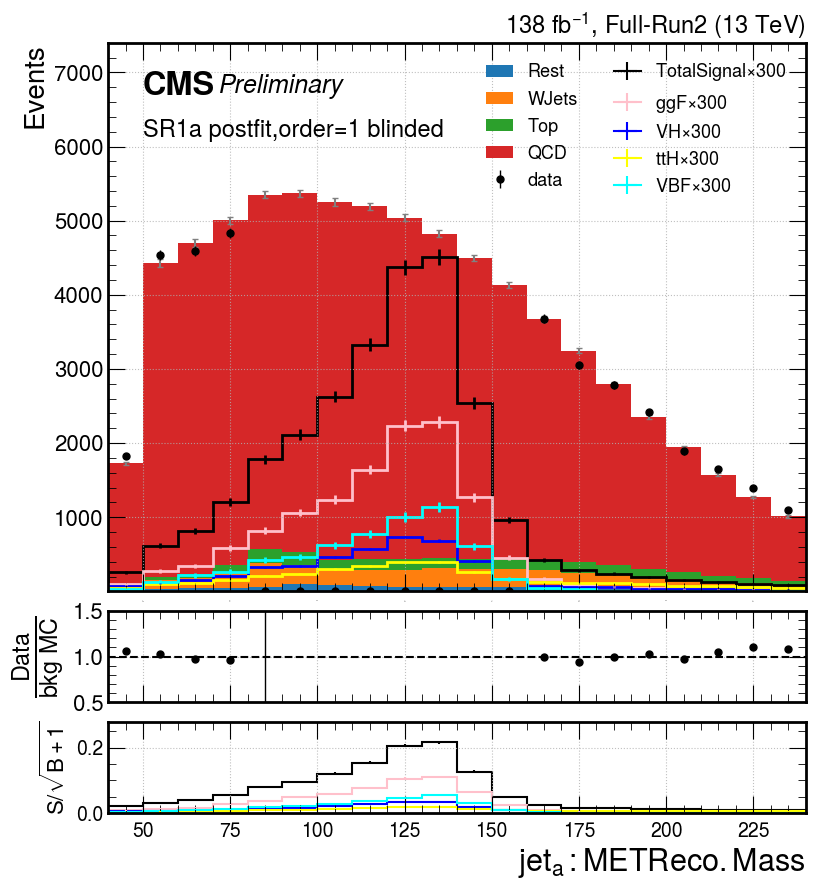

value is  [112624.93  262754.16  253880.84  244921.27  234876.47  224050.19
 212151.2   199211.9   184828.81  169017.72  151175.69  132990.86
 113510.72   96382.82   80354.34   65880.32   52913.816  41969.082
  32818.93   25572.477]
variance is  [ 45644.09313879 157797.79665723 123611.60516504 128788.04262793
  54739.37538037  50496.34815967  47182.56708496  44246.33198096
  41062.23977979  37317.36431592  32569.47406006  27520.9718208
  61028.59639526  56410.16313281  43366.87861633  32343.6214938
  23885.61594135  19912.73852078  15026.94743736  11334.68500877]
total error: [[236.72383029 430.58198556 386.62954061 402.14316512 286.69795174
  274.42336243 262.0644225  254.99842992 246.26650451 239.60513692
  226.03517449 211.98653786 290.94896194 280.71356478 248.84120398
  217.69849271 186.2311124  169.70423543 148.49645055 129.62172012]
 [236.72383029 430.58198556 386.62954061 402.14316512 286.69795174
  274.42336243 262.0644225  254.99842992 246.26650451 239.60513692
  226.03517449

/tmp/ipykernel_939497/1941715827.py:110: RuntimeWarning: invalid value encountered in divide
  ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
/tmp/ipykernel_939497/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_939497/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_939497/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h


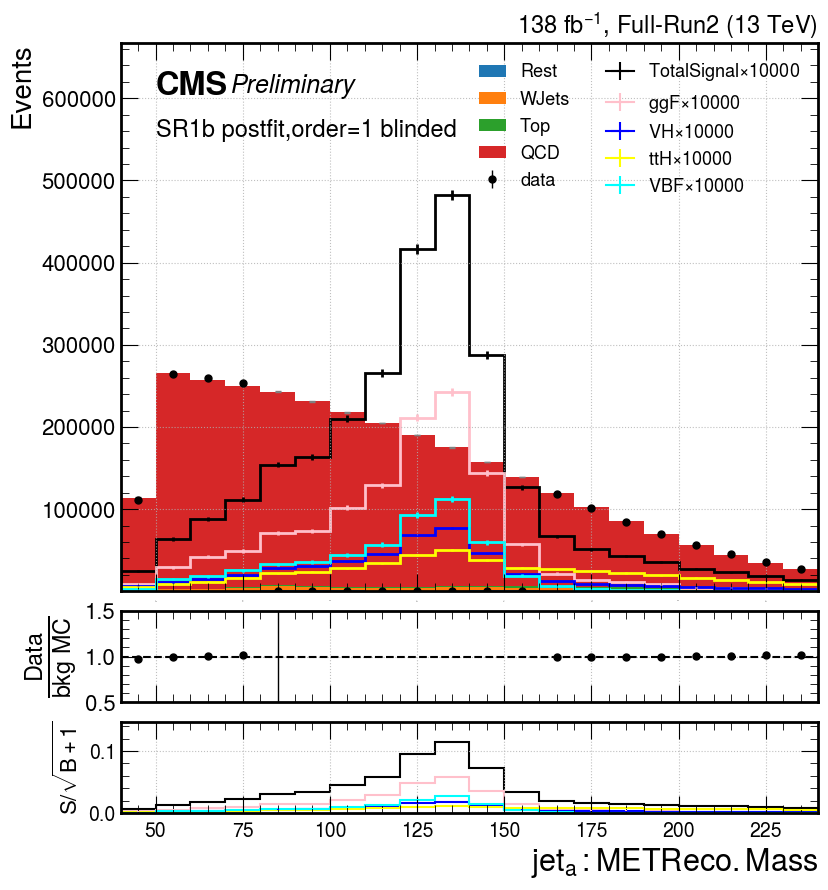

value is  [328371.75  742646.06  696258.06  652315.9   608027.75  564187.06
 520044.06  475699.75  430229.97  383753.75  335007.34  287803.62
 240022.48  199242.98  162472.11  130352.516 102500.59   79629.05
  61014.707  46604.414]
variance is  [2.33630124e+05 6.04838778e+05 5.29261214e+05 4.78995744e+05
 2.72656250e-03 6.71875000e-04 5.15625000e-04 4.25781250e-04
 2.32421875e-04 3.55468750e-04 2.20703125e-04 0.00000000e+00
 1.49963773e+05 1.39088819e+05 1.26278804e+05 8.38867338e+04
 7.27200830e+04 5.36471892e+04 3.92441715e+04 3.31655320e+04]


/tmp/ipykernel_939497/2123724067.py:34: RuntimeWarning: divide by zero encountered in divide
  number = h**2 / var
/tmp/ipykernel_939497/2123724067.py:51: RuntimeWarning: invalid value encountered in multiply
  up_error_bar *= var/h
/tmp/ipykernel_939497/2123724067.py:52: RuntimeWarning: invalid value encountered in multiply
  down_error_bar *= var/h
/tmp/ipykernel_939497/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_939497/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_939497/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h


total error: [[517.32606848 823.4941135  776.62865439 750.33687602  70.31086236
   66.14021358  56.98614431  54.79227267  54.68081166  55.54381624
   54.10550088  53.77356802 440.84639177 424.29821511 403.49471702
  332.19444609 307.36662572 264.61327646 225.53545876 206.48285884]
 [517.32606848 823.4941135  776.62865439 750.33687602  70.31086236
   66.14021358  56.98614431  54.79227267  54.68081166  55.54381624
   54.10550088  53.77356802 440.84639177 424.29821511 403.49471702
  332.19444609 307.36662572 264.61327646 225.53545876 206.48285884]]
Should scale signal *  38201.76577264102
Optimal cut = 4 20 0.07374618004569769


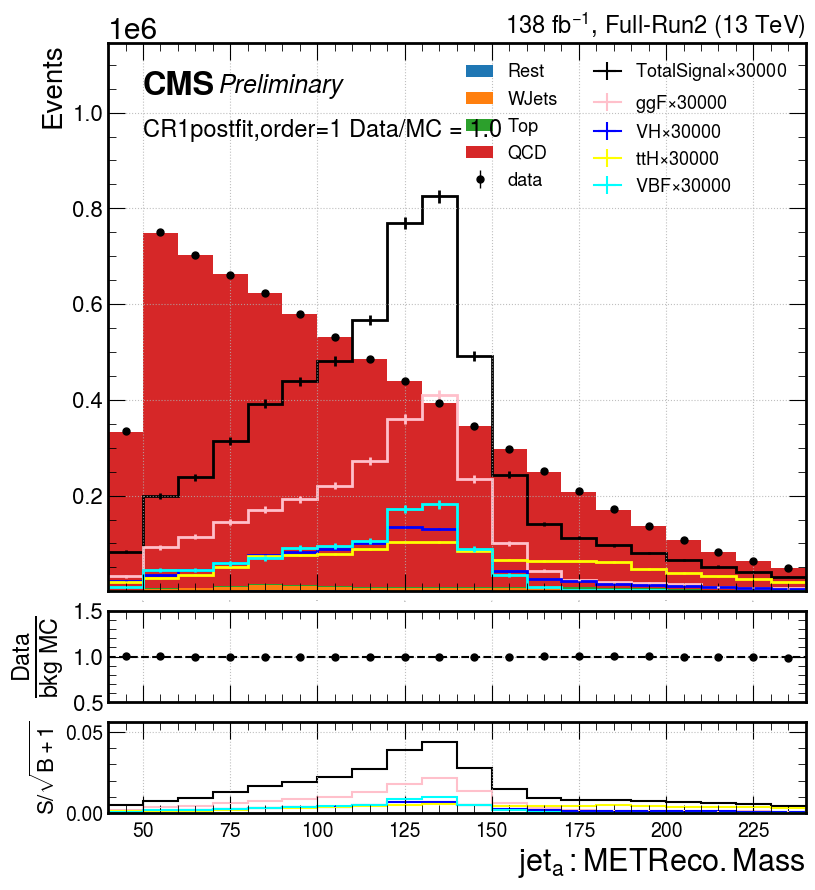

value is  [1761.9194 4318.1704 4385.898  4448.582  4487.4585 4498.9053 4474.2495
 4409.131  4289.1895 4108.4673 3845.262  3535.9434 3149.373  2790.038
 2424.3604 2069.5588 1729.0178 1425.1581 1157.0833  935.2488]
variance is  [ 457.26159042 2111.79938697 2081.53321663 2186.65055883 2314.81072939
 2415.62826643 2425.76391361 2337.9592964  2154.38883853 1898.34684884
 1584.57361218 1274.99926104 1004.247132    779.22335017  581.74804181
  418.43648876  308.50488789  210.05792727  155.79341711  111.72799726]
total error: [[26.99248665 57.36785952 58.59744493 60.49462372 61.72088864 65.30829767
  64.13731269 63.96090407 60.8264125  59.75514067 54.25369958 49.16086888
  45.89582103 40.45187082 35.31413904 30.31988137 27.40523875 24.80239799
  19.77997483 17.48595238]
 [26.99248665 57.36785952 58.59744493 60.49462372 61.72088864 65.30829767
  64.13731269 63.96090407 60.8264125  59.75514067 54.25369958 49.16086888
  45.89582103 40.45187082 35.31413904 30.31988137 27.40523875 24.80239799
  19.

/tmp/ipykernel_939497/1941715827.py:110: RuntimeWarning: invalid value encountered in divide
  ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
/tmp/ipykernel_939497/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_939497/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_939497/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h


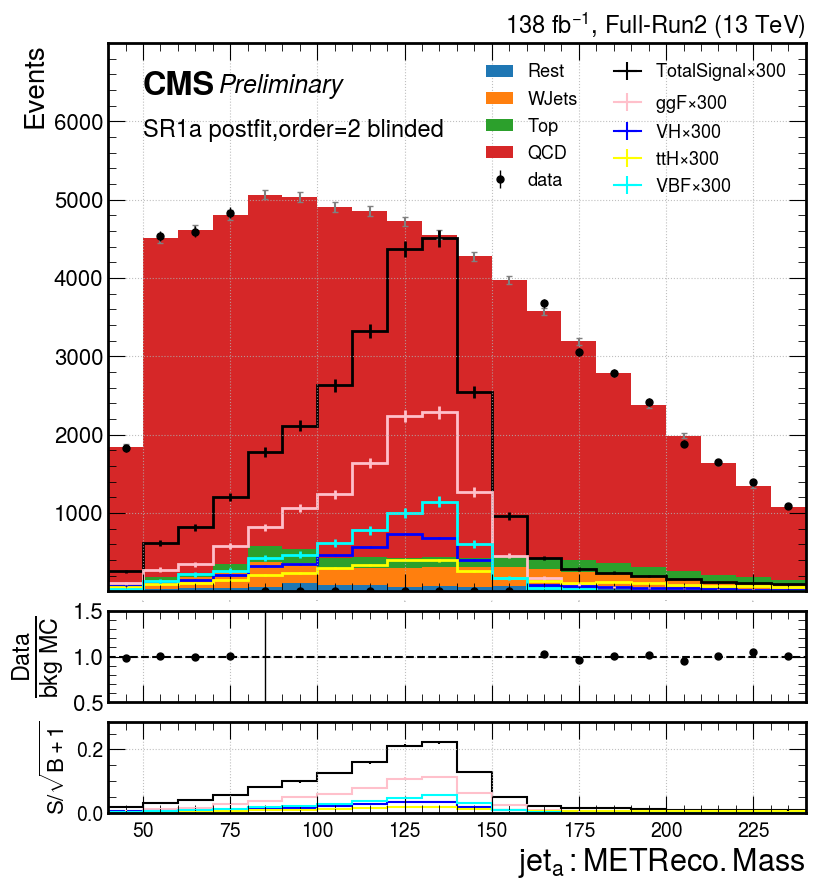

value is  [112288.516 262491.78  254039.12  245390.33  235700.73  225034.72
 213206.17  200261.45  185808.92  169878.9   151880.61  133525.72
 113800.51   96554.57   80423.97   65867.625  52841.46   41858.902
  32688.787  25434.404]
variance is  [ 53621.59120422 186763.85734814 172632.05383545 174420.09360547
 110431.22063086 111536.88354785 108737.49093115 101924.82900342
  91346.37011523  78158.78354492  63163.99968164  49018.4607334
  73901.09339954  58737.12283765  47202.25595825  34958.48915527
  26391.90753152  20183.00595068  15911.61637671  11164.30298933]
total error: [[254.64240803 465.50613573 450.53525016 460.90897204 385.04540472
  383.68082081 374.60261545 363.90699123 345.86391983 325.99703619
  296.88951813 267.49320987 315.75684764 285.56274999 257.85484267
  224.82705943 194.13725223 170.65863564 152.05325774 128.81850871]
 [254.64240803 465.50613573 450.53525016 460.90897204 385.04540472
  383.68082081 374.60261545 363.90699123 345.86391983 325.99703619
  296.8895181

/tmp/ipykernel_939497/1941715827.py:110: RuntimeWarning: invalid value encountered in divide
  ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
/tmp/ipykernel_939497/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_939497/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_939497/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h


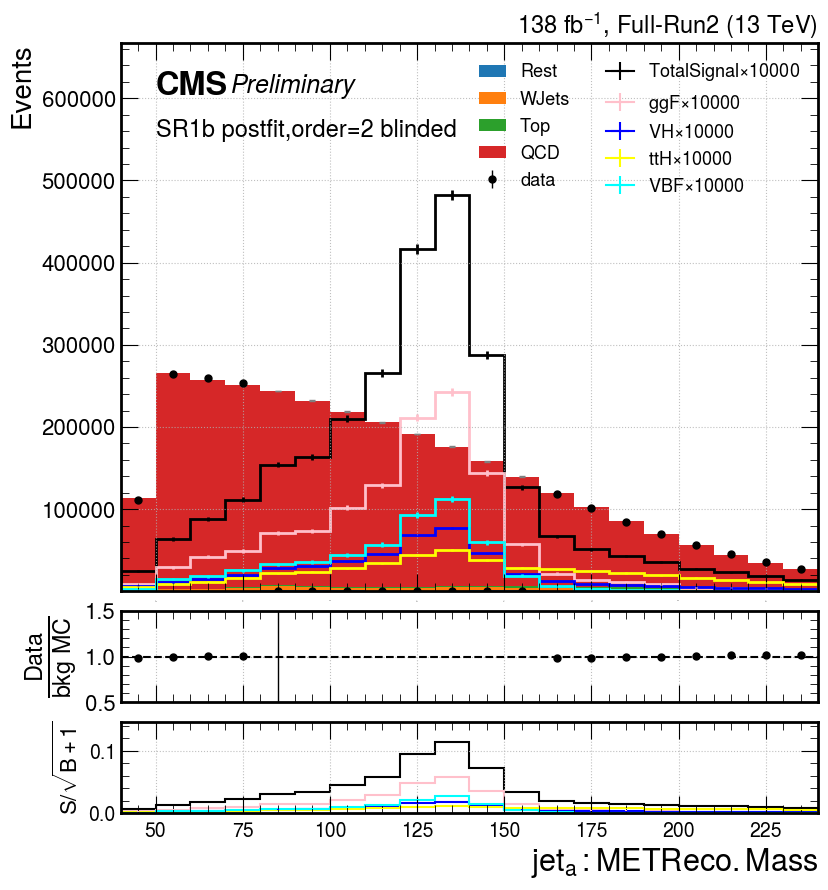

value is  [328598.8   742844.8   696197.3   652071.    608027.8   564187.06
 520044.1   475699.72  430229.97  383753.75  335007.3   287803.62
 239871.02  199166.06  162453.3   130374.69  102550.84   79698.16
  61093.777  46686.23 ]
variance is  [2.49103902e+05 5.46043336e+05 4.34868231e+05 4.52750377e+05
 1.25000000e-03 6.64062500e-04 4.66796875e-04 1.28125000e-03
 1.99218750e-04 3.71093750e-04 7.59765625e-04 0.00000000e+00
 1.77844176e+05 1.55403257e+05 1.10363558e+05 9.49676564e+04
 7.14523646e+04 5.25034996e+04 4.00566312e+04 2.94383891e+04]


/tmp/ipykernel_939497/2123724067.py:34: RuntimeWarning: divide by zero encountered in divide
  number = h**2 / var
/tmp/ipykernel_939497/2123724067.py:51: RuntimeWarning: invalid value encountered in multiply
  up_error_bar *= var/h
/tmp/ipykernel_939497/2123724067.py:52: RuntimeWarning: invalid value encountered in multiply
  down_error_bar *= var/h
/tmp/ipykernel_939497/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_939497/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_939497/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h


total error: [[533.07617121 784.72774801 708.57062801 731.10896382  70.2940012
   66.14006244  56.98504242  54.80743276  54.67968076  55.54422616
   54.11820865  53.77356802 475.31058715 445.56427902 380.34753287
  350.73060454 305.00575791 262.13107031 227.57556622 195.94499371]
 [533.07617121 784.72774801 708.57062801 731.10896382  70.2940012
   66.14006244  56.98504242  54.80743276  54.67968076  55.54422616
   54.11820865  53.77356802 475.31058715 445.56427902 380.34753287
  350.73060454 305.00575791 262.13107031 227.57556622 195.94499371]]
Should scale signal *  38202.695326423185
Optimal cut = 4 20 0.07374575229133494


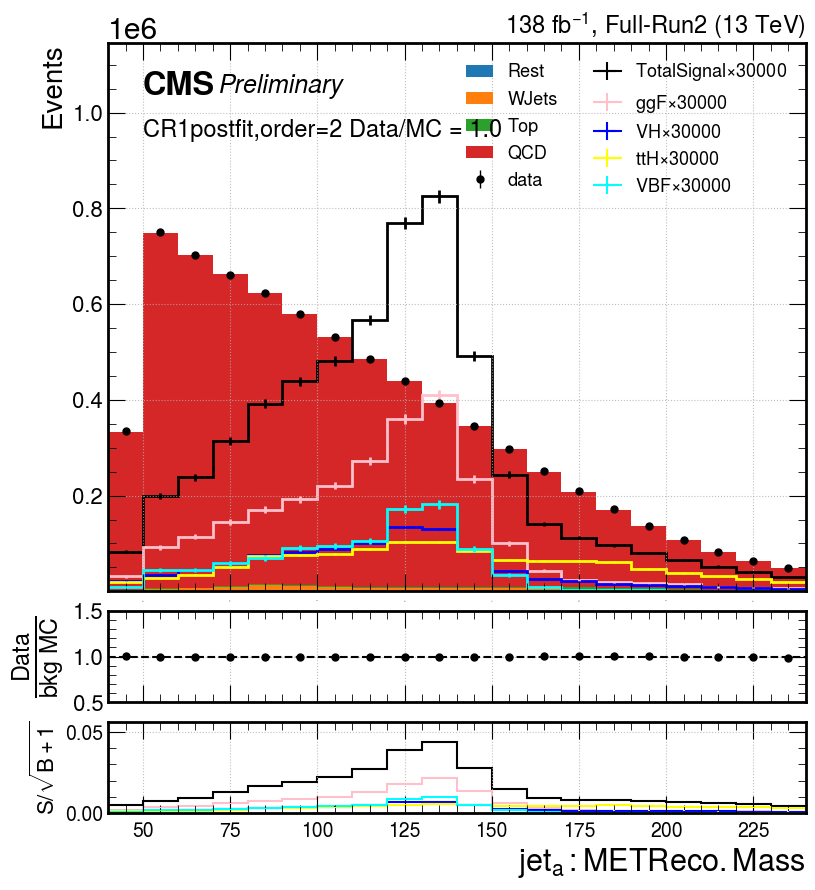

value is  [1743.0786  4315.4717  4403.1343  4470.2266  4526.423   4526.1196
 4484.504   4401.0874  4264.6313  4071.536   3801.7734  3491.8376
 3126.0537  2774.203   2416.2046  2068.264   1733.0929  1432.8436
 1166.6636   945.35394]
variance is  [ 490.16085832 2646.75598871 2806.54095711 3011.3585835  3201.25988058
 3267.45828945 3238.08654271 3127.46361977 2931.19983542 2653.80642446
 2283.19192545 1884.92611109 1460.71175209 1141.00676895  827.10691103
  597.40662354  411.27413396  296.50601307  202.59876115  149.33002794]
total error: [[27.74838772 62.86017335 65.95042014 68.60883593 70.18808588 73.32094136
  71.78945718 71.53218643 68.55157379 67.70022551 62.22975305 56.8694732
  52.42522117 46.31608993 39.95415184 34.30606332 30.12082606 27.52837292
  21.53197069 19.13587255]
 [27.74838772 62.86017335 65.95042014 68.60883593 70.18808588 73.32094136
  71.78945718 71.53218643 68.55157379 67.70022551 62.22975305 56.8694732
  52.42522117 46.31608993 39.95415184 34.30606332 30.12082606 

/tmp/ipykernel_939497/1941715827.py:110: RuntimeWarning: invalid value encountered in divide
  ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
/tmp/ipykernel_939497/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_939497/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_939497/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h


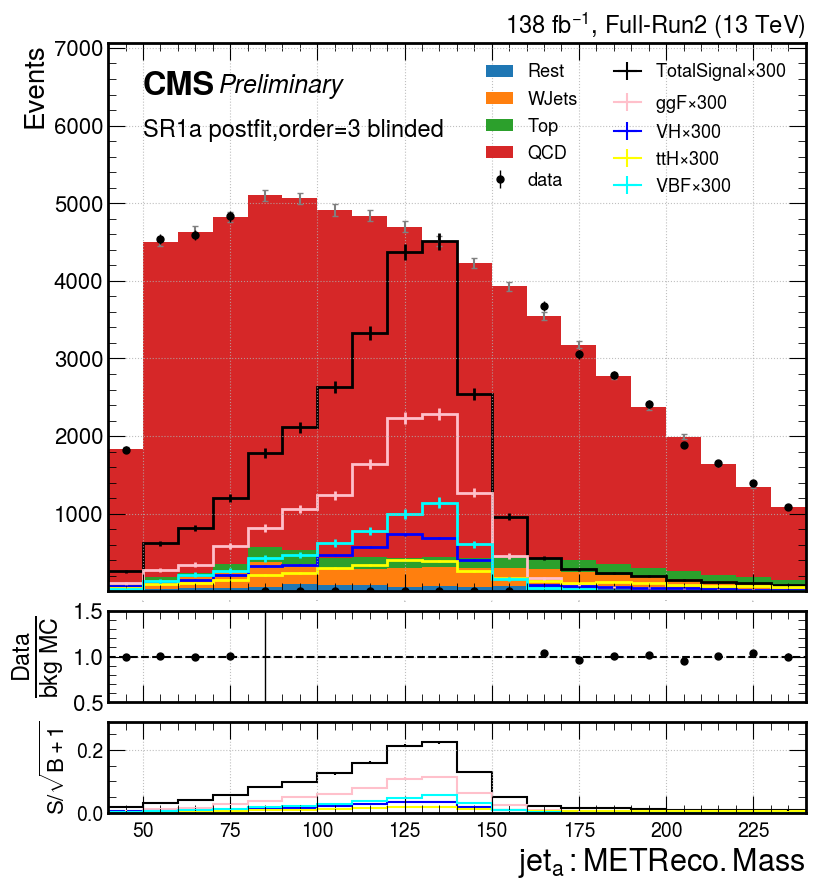

value is  [110234.234 261672.08  255647.2   248179.58  239984.86  228898.66
 216125.66  201989.3   186322.67  169337.84  150577.64  131812.22
 112606.016  95519.22   79685.445  65496.707  52848.363  42204.887
  33306.215  26249.738]
variance is  [ 52782.39437268 196000.47862939 199722.00883545 208739.90895117
 146430.80145801 143045.88499951 133907.01224951 120829.44753369
 105097.66994043  88183.67938379  70579.37819971  54645.10468799
  74569.4338783   57080.5168916   48928.70585693  34461.95324231
  29227.045293    21855.8392457   14645.71018237  13185.8555626 ]
total error: [[252.82324255 476.06369611 481.94780491 500.15328485 435.39625818
  427.92350718 410.78201048 392.25560989 367.81601797 343.3854804
  311.23281856 279.85500708 316.98334094 282.12061473 261.79238494
  223.4944725  202.64058349 176.42893599 146.93146364 137.98692424]
 [252.82324255 476.06369611 481.94780491 500.15328485 435.39625818
  427.92350718 410.78201048 392.25560989 367.81601797 343.3854804
  311.23281856

/tmp/ipykernel_939497/1941715827.py:110: RuntimeWarning: invalid value encountered in divide
  ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
/tmp/ipykernel_939497/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_939497/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_939497/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h


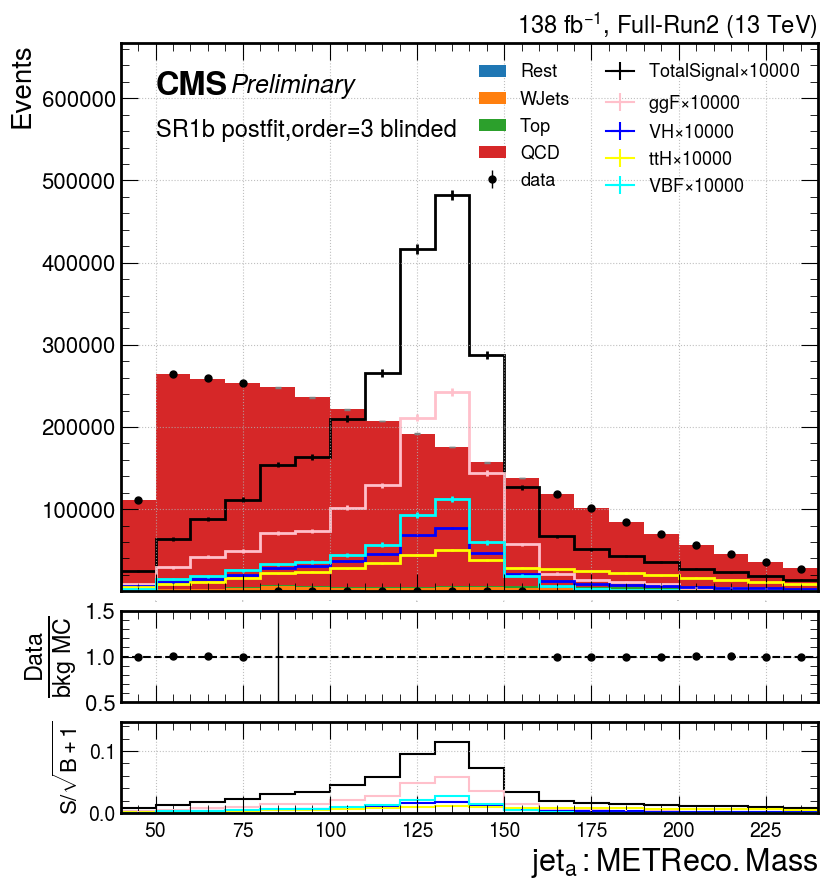

value is  [330666.47 743664.6  694577.3  649276.94 608027.8  564187.06 520044.06
 475699.75 430229.97 383753.75 335007.34 287803.62 241068.92 200199.9
 163186.89 130740.35 102540.64  79352.87  60481.96  45880.72]
variance is  [2.67536724e+05 4.95934772e+05 4.94429554e+05 4.37767006e+05
 1.21875000e-03 7.03125000e-04 5.27343750e-04 3.76953125e-04
 2.05078125e-04 3.90625000e-04 2.03125000e-04 0.00000000e+00
 1.79485422e+05 1.27736945e+05 1.03780405e+05 8.73187988e+04
 6.81783721e+04 5.19411163e+04 3.99988518e+04 3.13106786e+04]


/tmp/ipykernel_939497/2123724067.py:34: RuntimeWarning: divide by zero encountered in divide
  number = h**2 / var
/tmp/ipykernel_939497/2123724067.py:51: RuntimeWarning: invalid value encountered in multiply
  up_error_bar *= var/h
/tmp/ipykernel_939497/2123724067.py:52: RuntimeWarning: invalid value encountered in multiply
  down_error_bar *= var/h
/tmp/ipykernel_939497/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_939497/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_939497/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h


total error: [[551.21259247 750.0066499  752.28207463 719.88132693  70.29355646
   66.14080953  56.9864009   54.79105349  54.67988682  55.5447266
   54.10489699  53.77356802 477.25202434 408.75513197 370.28709213
  338.05991656 298.80988568 260.90058483 227.43117341 201.31703755]
 [551.21259247 750.0066499  752.28207463 719.88132693  70.29355646
   66.14080953  56.9864009   54.79105349  54.67988682  55.5447266
   54.10489699  53.77356802 477.25202434 408.75513197 370.28709213
  338.05991656 298.80988568 260.90058483 227.43117341 201.31703755]]
Should scale signal *  38202.86289489017
Optimal cut = 4 20 0.07373369052364392


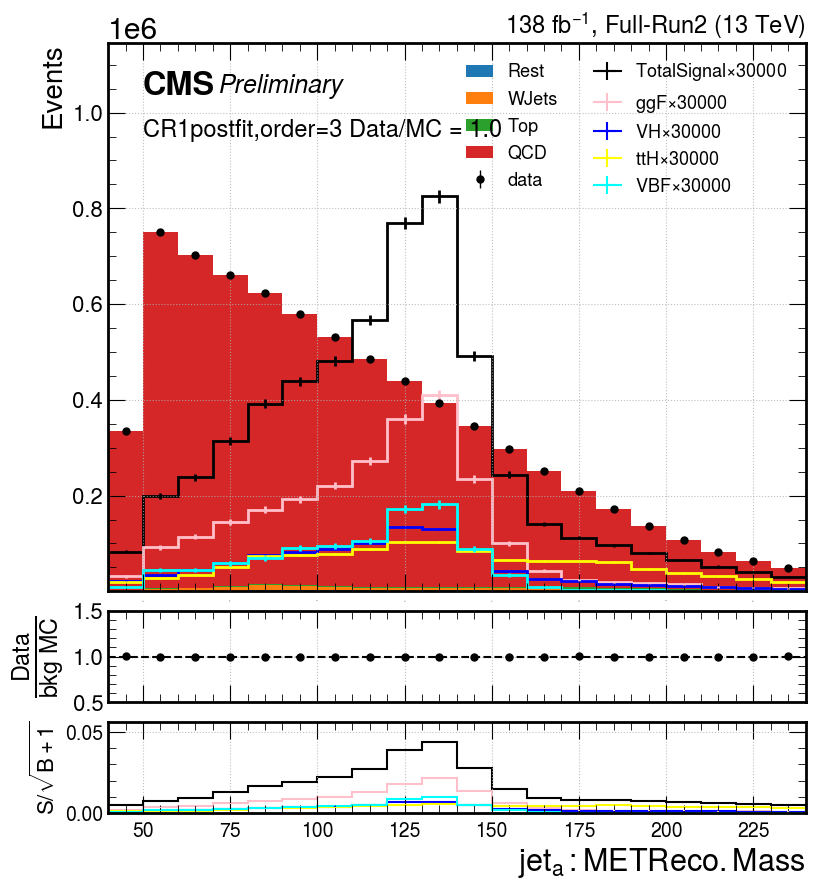

value is  [ 2.6878803 16.648561  34.65848   52.827797  69.675865  81.56422
 89.50999   93.35546   94.54118   90.37176   82.815834  74.225
 63.271675  52.379017  42.821796  34.50849   27.770868  21.599894
 16.658972  12.629751 ]
variance is  [ 9.32740691 37.00648008 56.55284669 67.38273294 72.91836675 71.29885838
 67.15730235 61.04424268 54.89604746 45.55538067 35.64385633 27.18005605
 19.39611452 13.6560303   8.7064134   5.80143269  3.63078189  2.21583542
  1.36642315  0.75435534]


/tmp/ipykernel_939497/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_939497/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_939497/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_939497/1941715827.py:110: RuntimeWarning: invalid value encountered in divide
  ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
/tmp/ipykernel_939497/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_939497/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_939497/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_939497/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_939497/2123

total error: [[ 2.43886806  6.53321645  8.64570009 10.02128856 11.54995808 12.28339378
  10.69833052 12.00199823 12.10938538 12.64270715  8.64904581 11.23215099
   8.69492031  7.93171821  6.83878458  6.41718207  3.8870797   3.46989705
   5.48189761  3.63818566]
 [ 7.76786156  9.16783973  8.7570653  10.10597014 12.42535725 13.68578028
  70.48941969 26.02827893 17.03413984 16.47803971  8.64904581 12.59911849
   9.49922568  8.8894328   7.71744916 14.90457211 30.09383     3.62499864
   8.92916902  5.65222379]]
Should scale signal *  106.6899995986786
Optimal cut = 2 13 0.40379290170701104


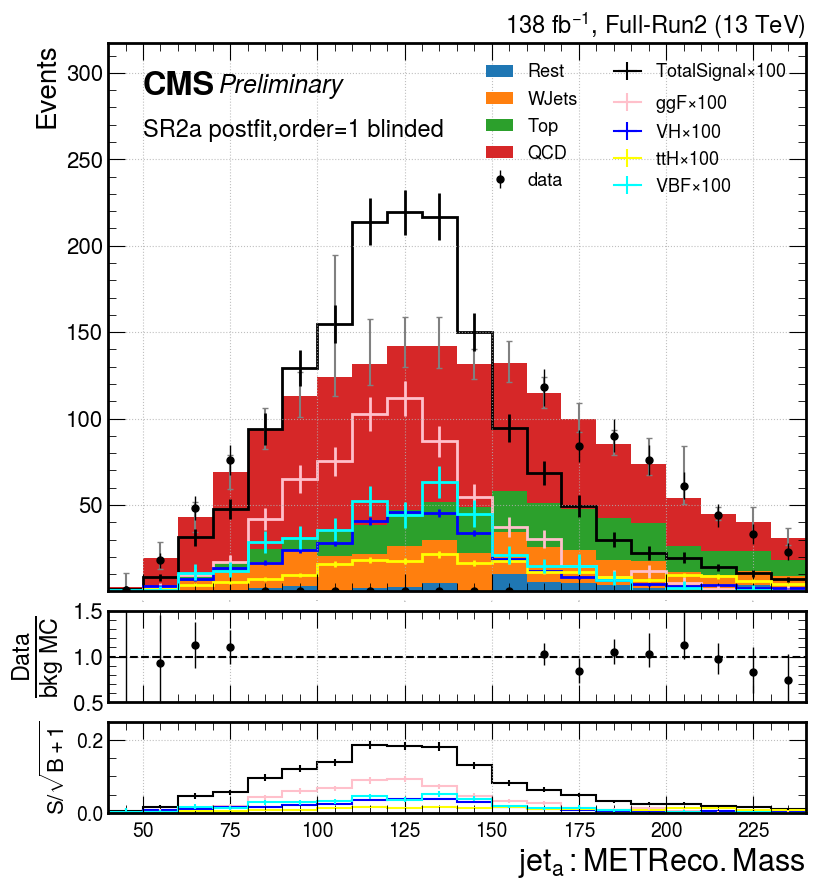

value is  [2668.0085  5671.3813  7287.3657  8155.572   8593.464   8448.313
 8047.0654  7456.4175  6825.987   5977.721   5071.9717  4245.2676
 3403.5781  2665.8564  2072.4722  1595.0514  1230.5302   920.51666
  684.79034  502.0451 ]
variance is  [ 988.13969385 3025.600469   3992.54702193 4133.9075821  2792.93739217
 2734.59969858 2593.27398683 2381.78573927 2168.19643092 1822.26012585
 1443.46769517 1113.41748516 1937.52896617 1434.4792529  1204.18537883
  819.07273391  519.28803535  419.95503618  322.51420661  234.39248934]
total error: [[37.79370883 64.11587294 74.44738408 76.53908414 67.31087961 66.73623547
  66.64414832 63.26718972 61.31091717 57.72013477 51.71425283 47.54052192
  58.11405725 50.39922465 45.80456842 39.24523398 31.09083266 27.57005453
  23.74369741 21.50869068]
 [37.79370883 64.11587294 74.44738408 76.53908414 67.31087961 66.73623547
  66.64414832 63.26718972 61.31091717 57.72013477 51.71425283 47.54052192
  58.11405725 50.39922465 45.80456842 39.24523398 31.0908326

/tmp/ipykernel_939497/1941715827.py:110: RuntimeWarning: invalid value encountered in divide
  ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
/tmp/ipykernel_939497/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_939497/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_939497/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h


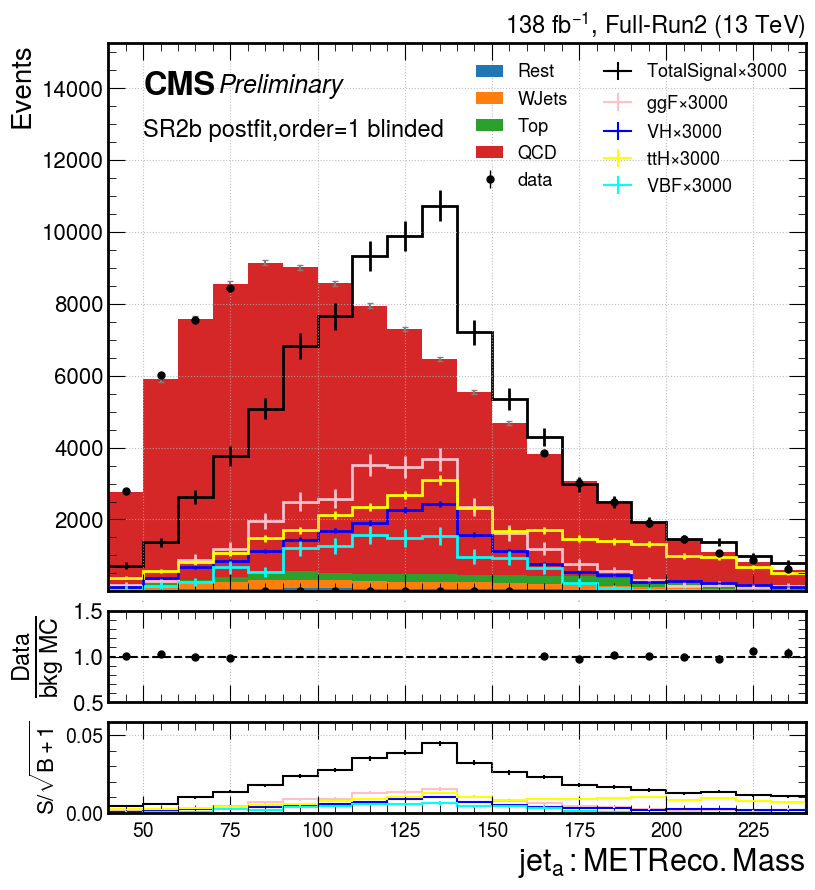

value is  [ 8246.788  17026.697  21267.406  23154.717  23752.8    22750.031
 21125.312  19095.168  17062.676  14593.321  12099.547   9901.416
  7765.0513  5952.0776  4530.456   3415.382   2581.966   1893.4707
  1381.4064   993.5854]
variance is  [6.57204443e+03 1.25022657e+04 1.76887551e+04 1.83122057e+04
 3.02124023e-06 0.00000000e+00 2.98309326e-06 2.60162354e-06
 1.09100342e-06 5.39779663e-07 3.89099121e-07 6.40869141e-07
 5.59921372e+03 4.33788152e+03 3.20847973e+03 3.16020139e+03
 2.15038653e+03 1.32281067e+03 1.07892597e+03 8.24237563e+02]


/tmp/ipykernel_939497/2123724067.py:34: RuntimeWarning: divide by zero encountered in divide
  number = h**2 / var
/tmp/ipykernel_939497/2123724067.py:51: RuntimeWarning: invalid value encountered in multiply
  up_error_bar *= var/h
/tmp/ipykernel_939497/2123724067.py:52: RuntimeWarning: invalid value encountered in multiply
  down_error_bar *= var/h
/tmp/ipykernel_939497/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_939497/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_939497/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h


total error: [[ 90.71565551 124.39029354 145.9101689  152.76595813  19.6690855
   19.70250029  17.83454654  19.12816733  17.7684095   16.22971157
   16.97480259  14.18826599  90.26128916  78.30840028  69.28745796
   67.29578839  55.06279944  45.1793834   40.20867373  33.52522774]
 [ 90.71565551 124.39029354 145.9101689  152.76595813  19.6690855
   19.70250029  17.83454654  19.12816733  17.7684095   16.22971157
   16.97480259  14.18826599  90.26128916  78.30840028  69.28745796
   67.29578839  55.06279944  45.1793834   40.20867373  33.52522774]]
Should scale signal *  12584.976928358015
Optimal cut = 4 20 0.041160957457099565


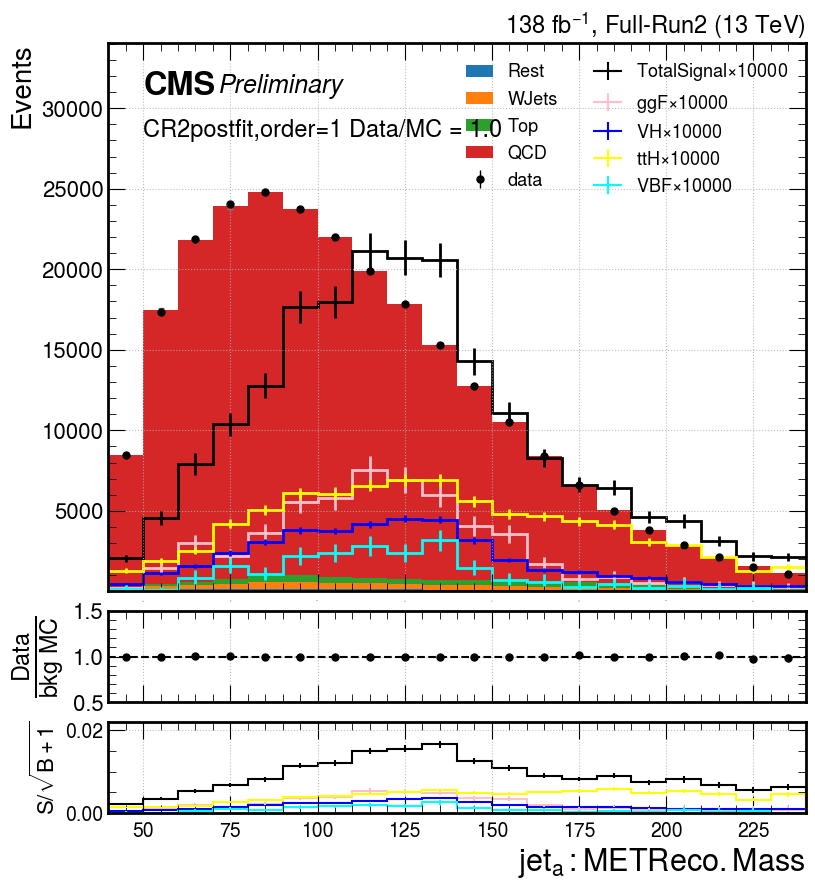

value is  [ 2.9334319 18.068064  37.381294  56.593266  73.67699   85.419945
 92.832565  95.87299   96.13086   90.973816  82.52677   73.21234
 62.114952  50.79276   40.99424   32.595314  25.867065  19.831589
 15.070612  11.25481  ]
variance is  [ 1.35736532  7.44689001 18.48691225 33.25593252 49.18669814 59.91238067
 65.71345695 66.38247526 64.44138169 56.86682293 47.10449381 38.13159567
 29.69409726 20.89491483 15.06730553 10.57901194  7.19821544  4.72041784
  3.21286052  2.0316291 ]


/tmp/ipykernel_939497/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_939497/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_939497/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_939497/1941715827.py:110: RuntimeWarning: invalid value encountered in divide
  ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
/tmp/ipykernel_939497/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_939497/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_939497/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_939497/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_939497/2123

total error: [[ 1.19212884  3.31598329  5.42517849  7.57938556 10.02405588 11.57983758
  10.60975821 12.33646081 12.72773793 13.43424397  9.54206954 12.19377993
   9.74004736  8.80740701  7.76978407  7.26110504  4.6645677   4.15398105
   6.10540202  4.19500159]
 [ 1.7879005   3.31598329  5.5365437   7.66406714 10.89945505 12.98222409
  70.40084738 26.36274151 17.65249239 17.26957652  9.54206954 13.56074743
  10.54435273  9.7651216   8.64844865 15.74849508 30.871318    4.30908265
   9.55267344  6.20903972]]
Should scale signal *  107.29804423124422
Optimal cut = 2 13 0.40058254246397634


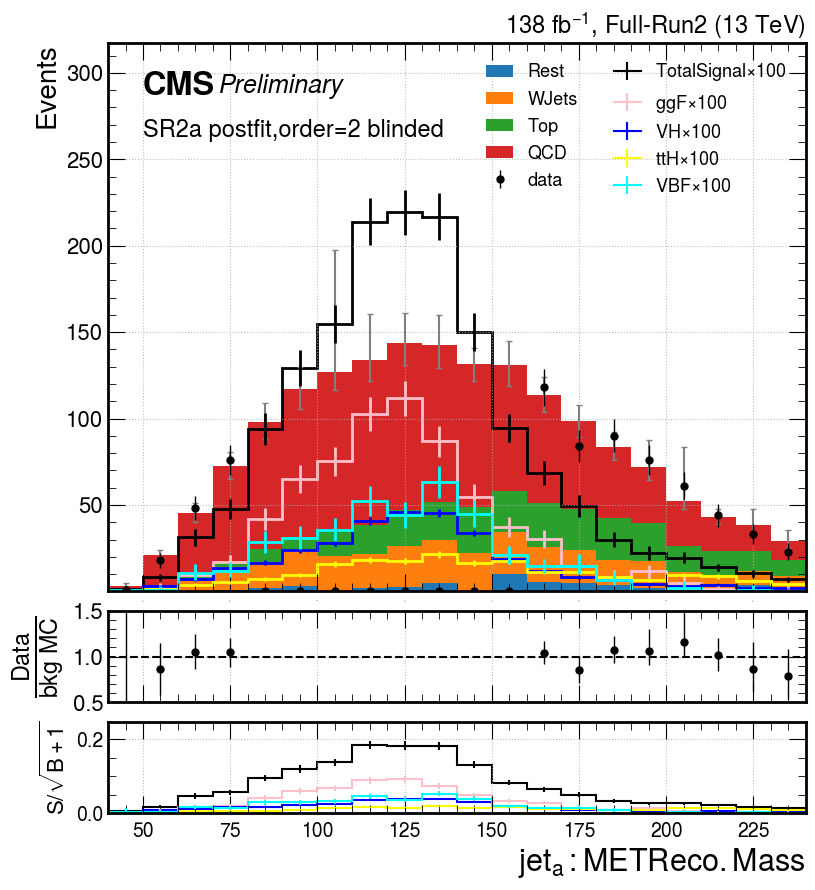

value is  [2719.4888 5713.281  7270.5444 8074.2935 8410.317  8219.872  7799.7397
 7213.7393 6603.397  5792.135  4930.114  4145.5947 3362.3303 2647.5479
 2070.5444 1604.006  1246.137   939.2468  704.3478  520.8153]
variance is  [1203.78687336 3454.97999279 5257.43000858 7102.58215174 5322.11067631
 5721.69368886 5684.03614912 5243.67111533 4639.43209238 3703.82175277
 2749.94151649 1979.47862555 2599.11138625 1744.22343312 1297.55848543
  976.11909662  646.93161183  474.96215163  342.95235063  252.52289805]
total error: [[41.05465122 67.88949343 83.76891611 96.52043208 87.41542828 90.08471295
  91.11249608 86.8768466  82.86039804 75.89122767 66.16114304 58.66394416
  65.07816654 54.28860574 47.12483383 41.86869199 33.73779072 28.8708766
  24.30398944 22.08977813]
 [41.05465122 67.88949343 83.76891611 96.52043208 87.41542828 90.08471295
  91.11249608 86.8768466  82.86039804 75.89122767 66.16114304 58.66394416
  65.07816654 54.28860574 47.12483383 41.86869199 33.73779072 28.8708766
  24.3

/tmp/ipykernel_939497/1941715827.py:110: RuntimeWarning: invalid value encountered in divide
  ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
/tmp/ipykernel_939497/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_939497/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_939497/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h


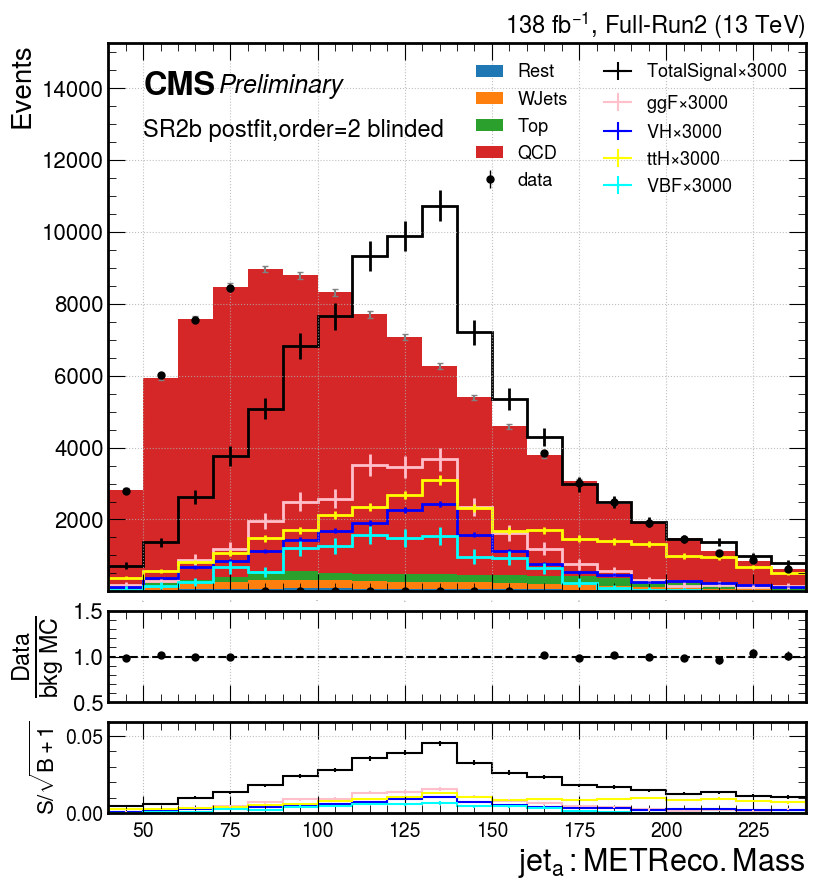

value is  [ 8196.62   16985.697  21283.81   23234.982  23752.803  22750.031
 21125.31   19095.168  17062.676  14593.32   12099.547   9901.417
  7808.909   5974.652   4537.1978  3411.0933  2570.5183  1878.5184
  1365.356    978.2153]
variance is  [5.88426893e+03 1.24822206e+04 1.49893368e+04 2.04166182e+04
 9.30786133e-07 0.00000000e+00 6.79016113e-07 2.47955322e-06
 1.07574463e-06 4.32968140e-07 4.02450562e-07 3.16619873e-07
 5.73697527e+03 4.57857831e+03 3.32528476e+03 2.63871857e+03
 1.79396353e+03 1.31668836e+03 9.67764574e+02 7.14592452e+02]


/tmp/ipykernel_939497/2123724067.py:34: RuntimeWarning: divide by zero encountered in divide
  number = h**2 / var
/tmp/ipykernel_939497/2123724067.py:51: RuntimeWarning: invalid value encountered in multiply
  up_error_bar *= var/h
/tmp/ipykernel_939497/2123724067.py:52: RuntimeWarning: invalid value encountered in multiply
  down_error_bar *= var/h
/tmp/ipykernel_939497/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_939497/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_939497/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h


total error: [[ 86.35649983 124.30062385 135.34203578 160.33009016  19.6683121
   19.70250029  17.83364341  19.12812903  17.76840217  16.22963487
   16.97481321  14.18802814  91.17622002  80.11099674  70.30929711
   62.44857757  51.04574524  45.09512009  38.47057924  31.54755193]
 [ 86.35649983 124.30062385 135.34203578 160.33009016  19.6683121
   19.70250029  17.83364341  19.12812903  17.76840217  16.22963487
   16.97481321  14.18802814  91.17622002  80.11099674  70.30929711
   62.44857757  51.04574524  45.09512009  38.47057924  31.54755193]]
Should scale signal *  12585.810420481292
Optimal cut = 4 20 0.04115968141495921


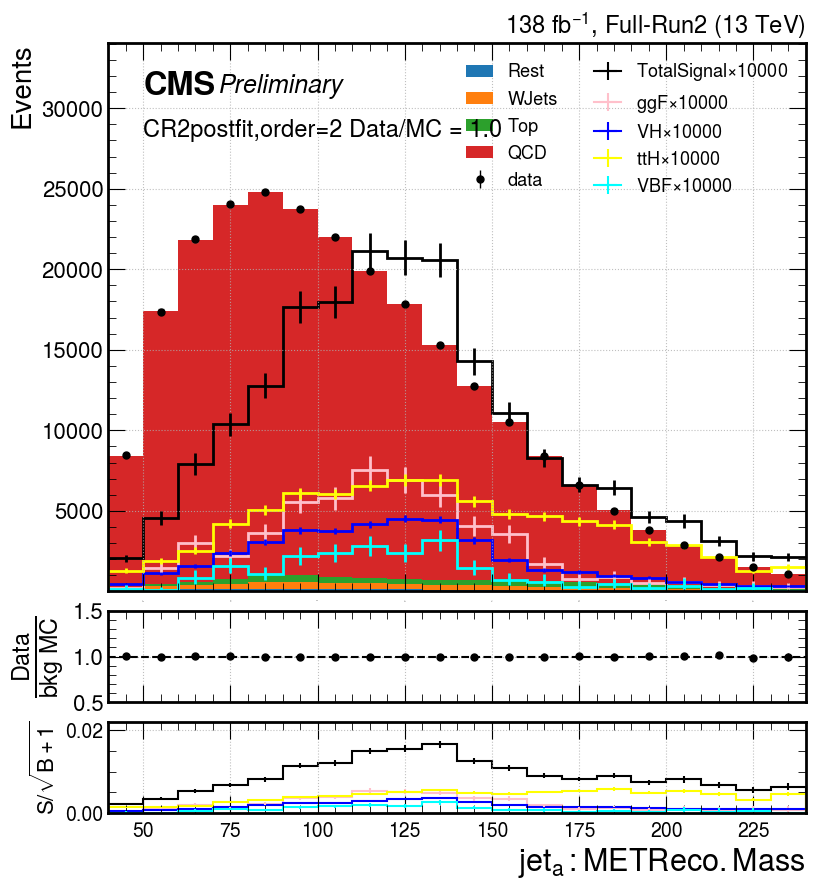

value is  [  2.632423  16.96575   36.488213  57.081745  76.3416    90.4821
 100.0265   104.5703   105.62683  100.21059   90.68087   79.833145
  66.79691   53.600075  42.189728  32.488583  24.775278  18.090057
  12.953846   9.001511]
variance is  [  2.26542964  11.06179387  24.46908893  41.53278066  61.44412642
  79.00194738  93.75838956 103.1218433  108.07331418 101.05153557
  86.54004045  70.55041535  53.48585441  36.69715292  24.98277691
  16.49337925  11.51333043   7.5928778    5.02680803   3.31578147]


/tmp/ipykernel_939497/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_939497/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_939497/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_939497/1941715827.py:110: RuntimeWarning: invalid value encountered in divide
  ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
/tmp/ipykernel_939497/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_939497/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_939497/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_939497/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_939497/2123

total error: [[ 1.47692615  3.9130118   6.07216145  8.25718314 10.84936331 12.7278328
  12.18626615 14.34380937 15.09603031 15.94567399 11.98148834 14.41813082
  11.60422068 10.29412899  8.88639874  8.06977005  5.37474847  4.73684656
   6.555011    4.59057804]
 [ 2.62702517  3.9130118   6.18352666  8.34186472 11.72476248 14.1302193
  71.97735531 28.37009007 20.02078477 19.78100654 11.98148834 15.78509832
  12.40852605 11.25184358  9.76506332 16.55716009 31.58149877  4.89194815
  10.00228242  6.60461617]]
Should scale signal *  110.88091750858202
Optimal cut = 2 13 0.3911477620934996


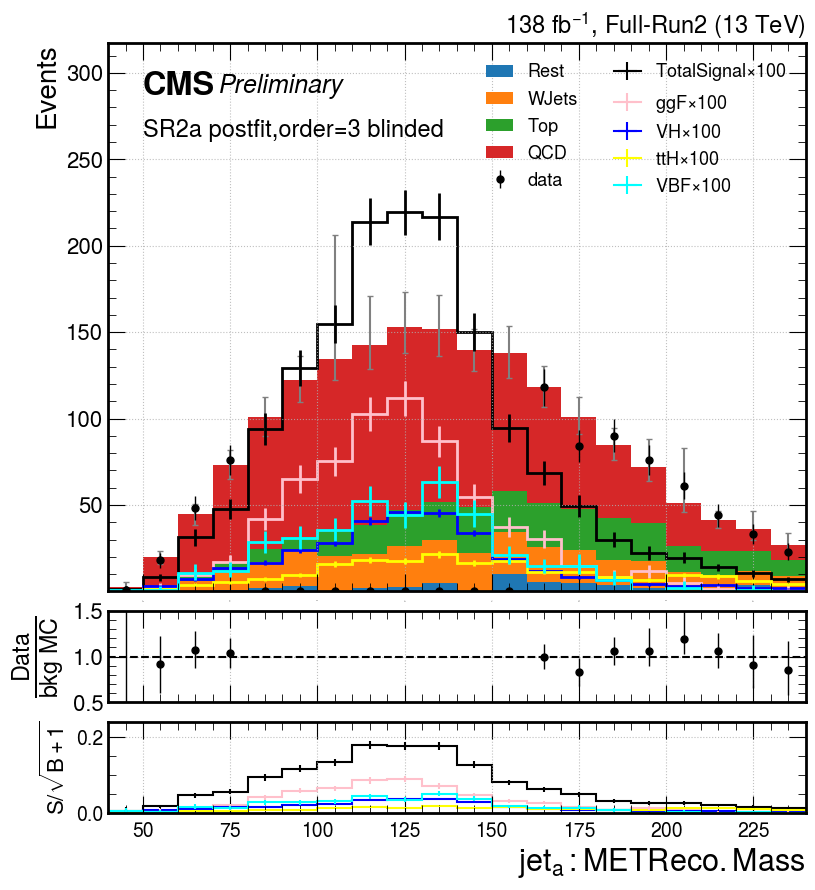

value is  [2724.0312  5715.51    7267.344   8067.1357  8399.449   8210.916
 7794.59    7213.038   6606.791   5798.472   4937.8657  4153.41
 3366.2795  2650.3901  2072.3113  1604.6025  1245.7139   938.0896
  702.64136  518.89746]
variance is  [1422.23256127 3961.38796274 6270.65694732 7959.56624821 7496.15130973
 7996.16010645 7836.55555464 7152.23007355 6304.38337373 5051.72321489
 3784.03662736 2751.03979882 3103.89378478 2239.4993394  1503.931264
 1073.15025096  755.49363767  492.32855938  366.01836901  278.52856518]
total error: [[ 44.07151908  72.04997287  90.44825836 101.4600146  101.04294506
  103.86408786 104.24427178  99.03450773  94.14716858  86.10767111
   75.23578186  66.62296734  69.80928617  59.84805424  49.88374613
   43.38475857  35.78918419  29.26572833  24.91662344  22.88798349]
 [ 44.07151908  72.04997287  90.44825836 101.4600146  101.04294506
  103.86408786 104.24427178  99.03450773  94.14716858  86.10767111
   75.23578186  66.62296734  69.80928617  59.84805424  49.8

/tmp/ipykernel_939497/1941715827.py:110: RuntimeWarning: invalid value encountered in divide
  ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
/tmp/ipykernel_939497/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_939497/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_939497/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h


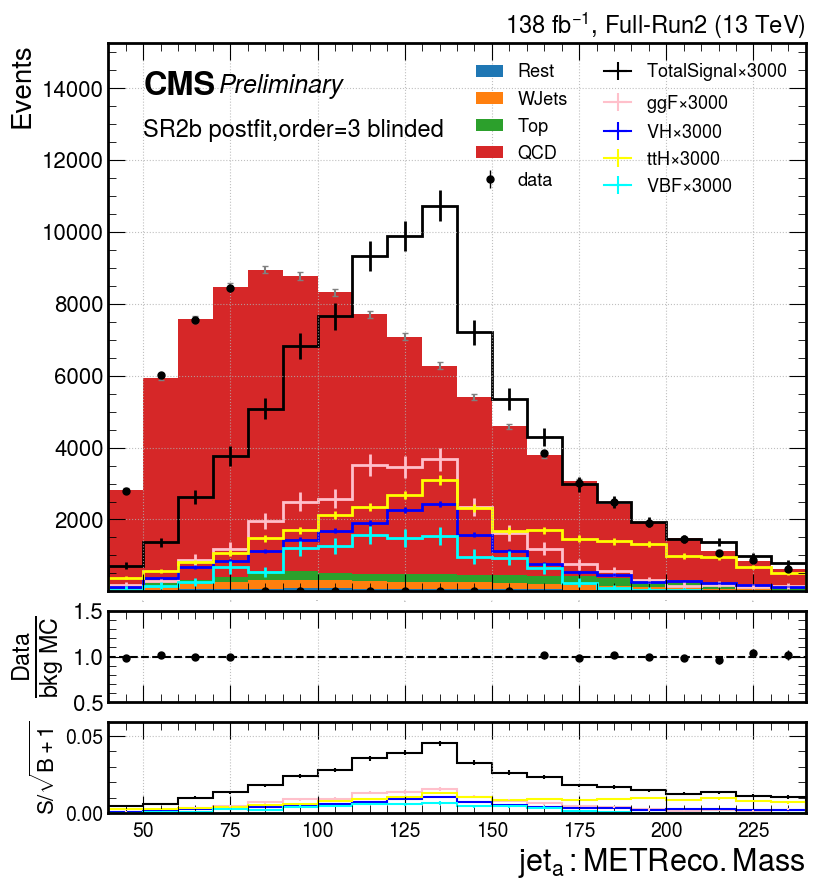

value is  [ 8192.482  16984.527  21287.668  23241.58   23752.803  22750.031
 21125.31   19095.166  17062.674  14593.32   12099.546   9901.417
  7802.6514  5970.309   4535.0938  3410.6829  2571.4478  1880.4962
  1367.8862   981.1553]
variance is  [6.35384669e+03 1.42124647e+04 1.58378385e+04 2.00100815e+04
 8.54492188e-07 0.00000000e+00 7.78198242e-07 1.38092041e-06
 2.70080566e-06 4.65393066e-07 4.94003296e-07 3.31878662e-07
 5.41984000e+03 4.96011531e+03 3.45885065e+03 2.83735476e+03
 2.08009880e+03 1.49686241e+03 9.80588843e+02 7.87779464e+02]


/tmp/ipykernel_939497/2123724067.py:34: RuntimeWarning: divide by zero encountered in divide
  number = h**2 / var
/tmp/ipykernel_939497/2123724067.py:51: RuntimeWarning: invalid value encountered in multiply
  up_error_bar *= var/h
/tmp/ipykernel_939497/2123724067.py:52: RuntimeWarning: invalid value encountered in multiply
  down_error_bar *= var/h
/tmp/ipykernel_939497/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_939497/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_939497/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h


total error: [[ 89.35852947 131.79280687 138.75956419 158.90036007  19.66827172
   19.70250029  17.83370154  19.1277295   17.7690084   16.22965907
   16.97488167  14.18804154  89.05295826  82.87389227  71.4560093
   64.34694626  54.29863824  47.49822552  38.67601997  32.88309923]
 [ 89.35852947 131.79280687 138.75956419 158.90036007  19.66827172
   19.70250029  17.83370154  19.1277295   17.7690084   16.22965907
   16.97488167  14.18804154  89.05295826  82.87389227  71.4560093
   64.34694626  54.29863824  47.49822552  38.67601997  32.88309923]]
Should scale signal *  12585.830801461685
Optimal cut = 4 20 0.04116022832892564


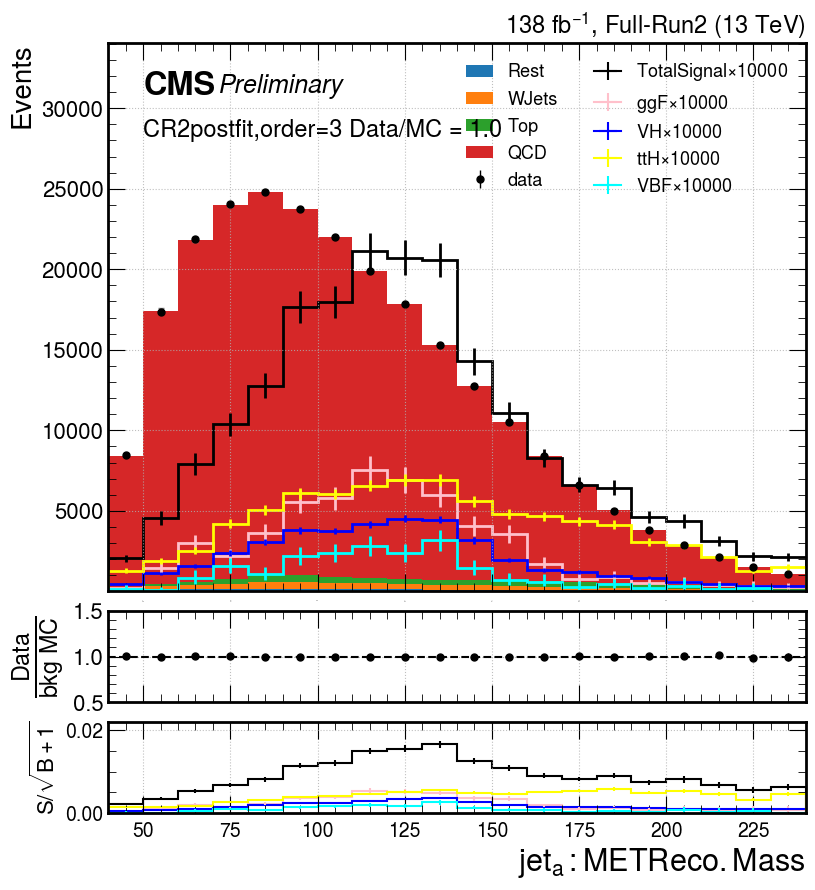

value is  [9.9999997e-05 4.2442846e-01 2.0676033e+00 6.0370889e+00 9.1249523e+00
 1.1328298e+01 1.4943259e+01 1.6269817e+01 1.6042843e+01 1.5739626e+01
 1.5117167e+01 1.2823841e+01 1.1702879e+01 9.7362270e+00 9.1062260e+00
 5.9978814e+00 5.1721945e+00 4.4552569e+00 1.7946794e+00 2.8396285e+00]
variance is  [1.93758787e-23 9.58759580e+00 7.31310295e+01 2.86760999e+02
 3.48168158e+02 3.18416787e+02 3.50159608e+02 2.74168557e+02
 1.81964891e+02 1.22742480e+02 8.11745298e+01 4.28012706e+01
 2.78708056e+01 1.48720615e+01 1.02403236e+01 3.93087445e+00
 2.78615361e+00 2.05188949e+00 4.44316122e-01 8.03187591e-01]


/tmp/ipykernel_939497/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_939497/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_939497/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_939497/1941715827.py:110: RuntimeWarning: invalid value encountered in divide
  ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
/tmp/ipykernel_939497/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_939497/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_939497/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_939497/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_939497/2123

total error: [[4.40180393e-12 7.66019951e-01 3.23354406e+00 7.73280633e+00
  1.07731834e+01 1.46936848e+01 1.63790207e+01 1.57952644e+01
  1.39920765e+01 1.25857121e+01 1.06386996e+01 9.77742211e+00
  9.26953468e+00 6.25040336e+00 7.21669204e+00 5.25255425e+00
  3.78296245e+00 3.09366010e+00 2.02503643e+00 2.32050130e+00]
 [4.40180393e-12 4.21655452e+01 6.74182567e+01 9.20403928e+01
  7.62704545e+01 6.30316935e+01 5.39264007e+01 4.08424097e+01
  2.99054208e+01 2.33271670e+01 1.76160463e+01 1.50502777e+01
  1.44334148e+01 8.35320275e+00 1.06249837e+01 6.96392094e+00
  4.63351986e+00 3.86703362e+00 2.60073392e+00 2.55137804e+00]]
Should scale signal *  60.47348424160879
Optimal cut = 1 11 0.4894288090481874


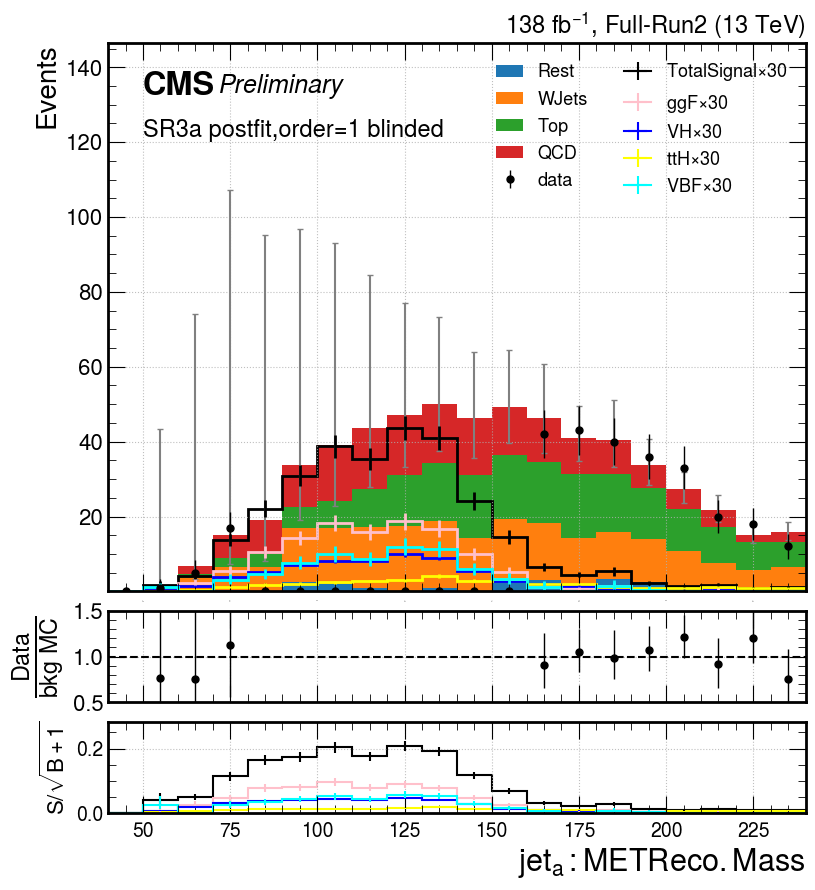

value is  [9.9999997e-05 3.2629677e+01 9.8579773e+01 2.1228603e+02 2.5742459e+02
 2.6946271e+02 3.0967911e+02 3.0062473e+02 2.6887405e+02 2.4244809e+02
 2.1626468e+02 1.7182716e+02 1.4789255e+02 1.1672152e+02 1.0407477e+02
 6.5627304e+01 5.4378296e+01 4.5151138e+01 1.7580889e+01 2.6955385e+01]
variance is  [2.10699446e-23 1.25281059e+01 6.90841113e+01 2.54266116e+02
 2.26474407e+02 2.26569084e+02 2.80599436e+02 2.54739292e+02
 2.01369576e+02 1.65473236e+02 1.35544093e+02 8.93525075e+01
 1.40540980e+02 1.10772774e+02 8.77118949e+01 5.63676941e+01
 4.80130340e+01 3.82517637e+01 1.77127693e+01 2.38815118e+01]


/tmp/ipykernel_939497/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_939497/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_939497/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_939497/1941715827.py:110: RuntimeWarning: invalid value encountered in divide
  ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
/tmp/ipykernel_939497/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_939497/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_939497/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_939497/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_939497/2123

total error: [[4.59020083e-12 5.32778664e+00 1.19344525e+01 2.09537028e+01
  2.22714998e+01 2.28776673e+01 2.35909834e+01 2.39099927e+01
  2.17080101e+01 2.17877783e+01 1.88945303e+01 1.73928303e+01
  1.88969492e+01 1.76169488e+01 1.52699917e+01 1.45414439e+01
  1.27027887e+01 1.15134927e+01 7.17445021e+00 7.46884186e+00]
 [4.59020083e-12 6.79523864e+00 1.34327079e+01 2.19260545e+01
  2.39816258e+01 2.55213333e+01 2.53693461e+01 2.60431122e+01
  2.17080101e+01 2.17877783e+01 2.07758082e+01 1.89957569e+01
  2.09138898e+01 1.76169488e+01 1.52699917e+01 1.65957186e+01
  1.55832916e+01 1.35078238e+01 7.17445021e+00 7.46884186e+00]]
Should scale signal *  390.59835524836916
Optimal cut = 1 20 0.17505366616033735


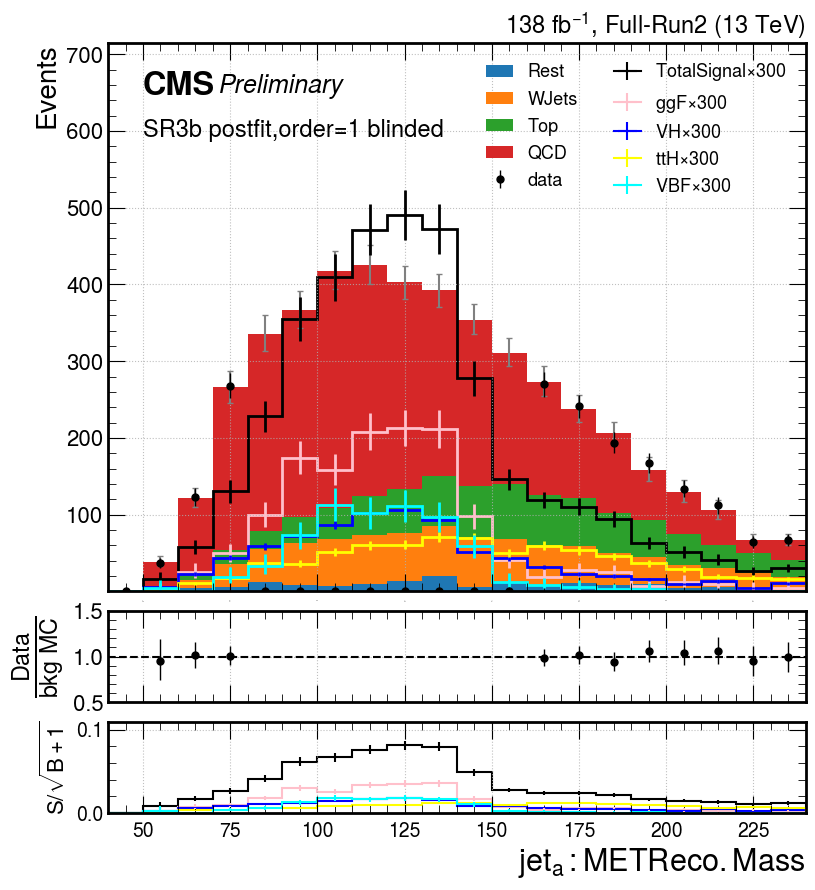

value is  [  0.       104.92475  306.68466  639.62354  751.9397   763.7776
 852.5049   804.4265   699.88605  614.3782   533.883    413.50922
 347.17435  267.43726  232.8817   143.49313  116.24007   94.40601
  35.973286  53.999767]
variance is  [0.00000000e+00 8.12906174e+01 2.64245047e+02 5.34428225e+02
 1.41561031e-10 1.16229057e-09 2.01165676e-09 1.78813934e-10
 1.70618296e-09 1.72853470e-09 1.09523535e-09 1.52736902e-10
 3.35080673e+02 3.01497511e+02 2.47824803e+02 1.97098269e+02
 1.39492782e+02 1.18776628e+02 6.54929190e+01 7.49357547e+01]


/tmp/ipykernel_939497/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_939497/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_939497/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_939497/1941715827.py:110: RuntimeWarning: invalid value encountered in divide
  ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
/tmp/ipykernel_939497/1941715827.py:111: RuntimeWarning: invalid value encountered in divide
  hep.histplot(h/bkg_h, bins=hist.axes[0].edges, yerr=ratio_error, color='black', histtype='errorbar', density=density, stack=False, ax=ax1)
/tmp/ipykernel_939497/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_939497/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_939497/21

total error: [[ 0.         11.10045181 18.48241408 29.11259964  6.88183619  6.48299233
   7.19130958  7.58410244  9.85858136  6.51806287  8.94186784  8.92319671
  24.81974781 21.84350299 21.0352793  18.81636981 17.04887952 16.11842003
  12.32861129 12.24987485]
 [ 0.         12.29391075 18.48241408 30.4724491   8.40142709  6.48299233
   7.19130958  7.58410244  9.85858136  6.51806287  8.94186784  8.92319671
  24.81974781 21.84350299 21.7751618  18.81636981 17.04887952 16.11842003
  12.32861129 12.24987485]]
Should scale signal *  1568.6975192278765
Optimal cut = 3 20 0.06256829716700808


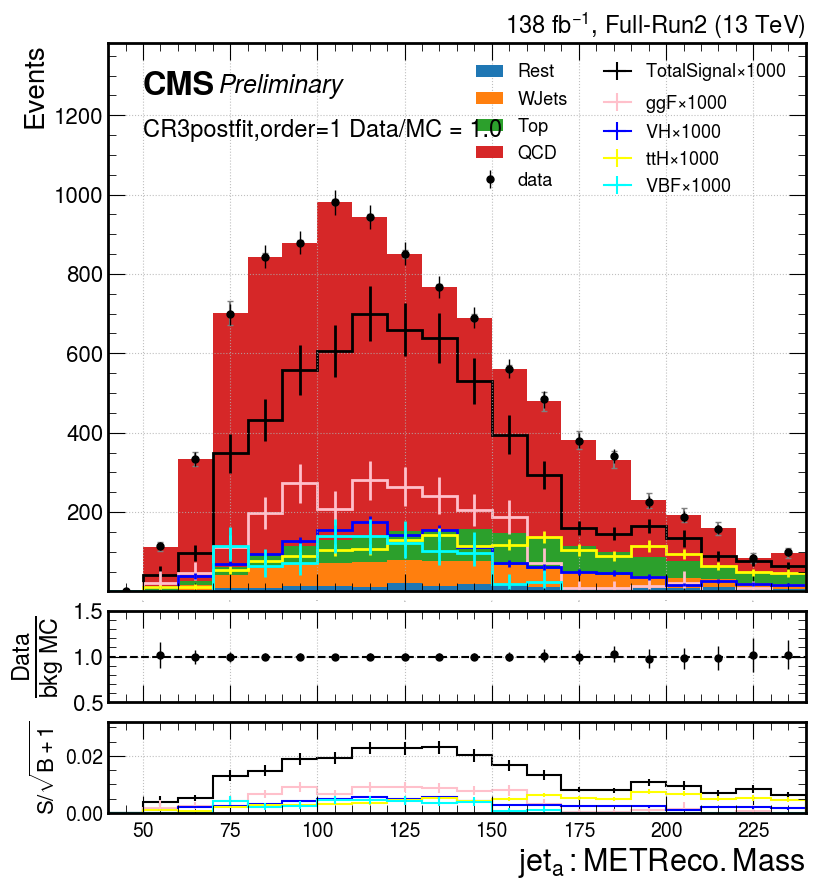

value is  [1.00000005e-04 4.23318177e-01 2.06976628e+00 6.06129980e+00
 9.15995789e+00 1.13806639e+01 1.50240860e+01 1.63706150e+01
 1.61548462e+01 1.58618908e+01 1.52464848e+01 1.29436226e+01
 1.18782845e+01 9.87929821e+00 9.23332882e+00 6.08292818e+00
 5.24039650e+00 4.50664568e+00 1.81663859e+00 2.85969758e+00]
variance is  [3.29284058e-23 1.15857631e+01 7.62832467e+01 2.64243574e+02
 2.97506019e+02 2.47776738e+02 2.49788519e+02 1.81318960e+02
 1.13549846e+02 7.41651139e+01 4.91922526e+01 2.71658572e+01
 2.00852475e+01 1.18183036e+01 9.74101564e+00 4.51037156e+00
 3.41708307e+00 2.83273989e+00 7.42598203e-01 1.42669309e+00]


/tmp/ipykernel_939497/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_939497/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_939497/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_939497/1941715827.py:110: RuntimeWarning: invalid value encountered in divide
  ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
/tmp/ipykernel_939497/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_939497/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_939497/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_939497/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_939497/2123

total error: [[5.73832775e-12 7.65257374e-01 3.23747841e+00 7.73552743e+00
  1.06882717e+01 1.43524140e+01 1.54235353e+01 1.40944782e+01
  1.19319126e+01 1.06326777e+01 8.95237637e+00 8.60887252e+00
  8.54463676e+00 5.86668297e+00 7.14050272e+00 5.38995139e+00
  3.95566523e+00 3.33026312e+00 2.20176571e+00 2.58356414e+00]
 [5.73832775e-12 5.09593520e+01 7.01541461e+01 8.48619665e+01
  6.58085797e+01 5.12841014e+01 4.11325492e+01 2.97033172e+01
  2.12786496e+01 1.68061962e+01 1.29124725e+01 1.22055388e+01
  1.28095460e+01 7.55165161e+00 1.04598733e+01 7.20891094e+00
  4.94837013e+00 4.31487728e+00 2.98853130e+00 3.41520582e+00]]
Should scale signal *  60.62336498854583
Optimal cut = 1 11 0.4888986735219301


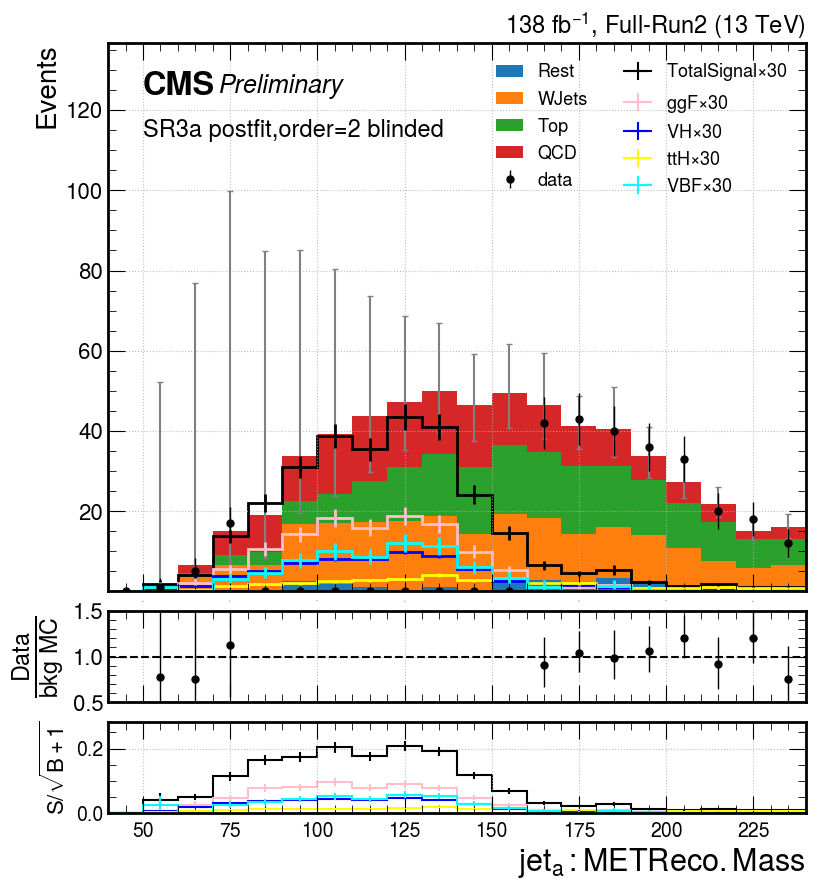

value is  [1.00000005e-04 3.31383820e+01 9.91556396e+01 2.11823669e+02
 2.54576721e+02 2.64901337e+02 3.03205109e+02 2.93663879e+02
 2.62470520e+02 2.36867889e+02 2.11751694e+02 1.68824768e+02
 1.46683746e+02 1.16302521e+02 1.04235580e+02 6.61880417e+01
 5.52040596e+01 4.61418571e+01 1.81401482e+01 2.79350815e+01]
variance is  [3.16578564e-23 1.51803532e+01 8.18400320e+01 2.83137452e+02
 3.26896143e+02 3.58432107e+02 4.79131765e+02 4.58013673e+02
 3.70779652e+02 3.04023593e+02 2.43372404e+02 1.54657207e+02
 1.72132467e+02 1.26654622e+02 1.05769489e+02 6.53282012e+01
 5.50560429e+01 3.96419991e+01 1.94579201e+01 2.50239271e+01]


/tmp/ipykernel_939497/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_939497/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_939497/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_939497/1941715827.py:110: RuntimeWarning: invalid value encountered in divide
  ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
/tmp/ipykernel_939497/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_939497/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_939497/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_939497/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_939497/2123

total error: [[5.62653144e-12 5.68447745e+00 1.26693153e+01 2.18346674e+01
  2.53027026e+01 2.67577590e+01 2.87289594e+01 2.93506926e+01
  2.67731746e+01 2.63604110e+01 2.28525877e+01 2.03763100e+01
  2.01618774e+01 1.83461779e+01 1.61889583e+01 1.51161882e+01
  1.31936210e+01 1.16248811e+01 7.37690935e+00 7.58436267e+00]
 [5.62653144e-12 7.15192945e+00 1.41675707e+01 2.28070192e+01
  2.70128286e+01 2.94014250e+01 3.05073221e+01 3.14838121e+01
  2.67731746e+01 2.63604110e+01 2.47338656e+01 2.19792365e+01
  2.21788181e+01 1.83461779e+01 1.61889583e+01 1.71704629e+01
  1.60741239e+01 1.36192122e+01 7.37690935e+00 7.58436267e+00]]
Should scale signal *  387.4851010918163
Optimal cut = 1 20 0.17575534382249056


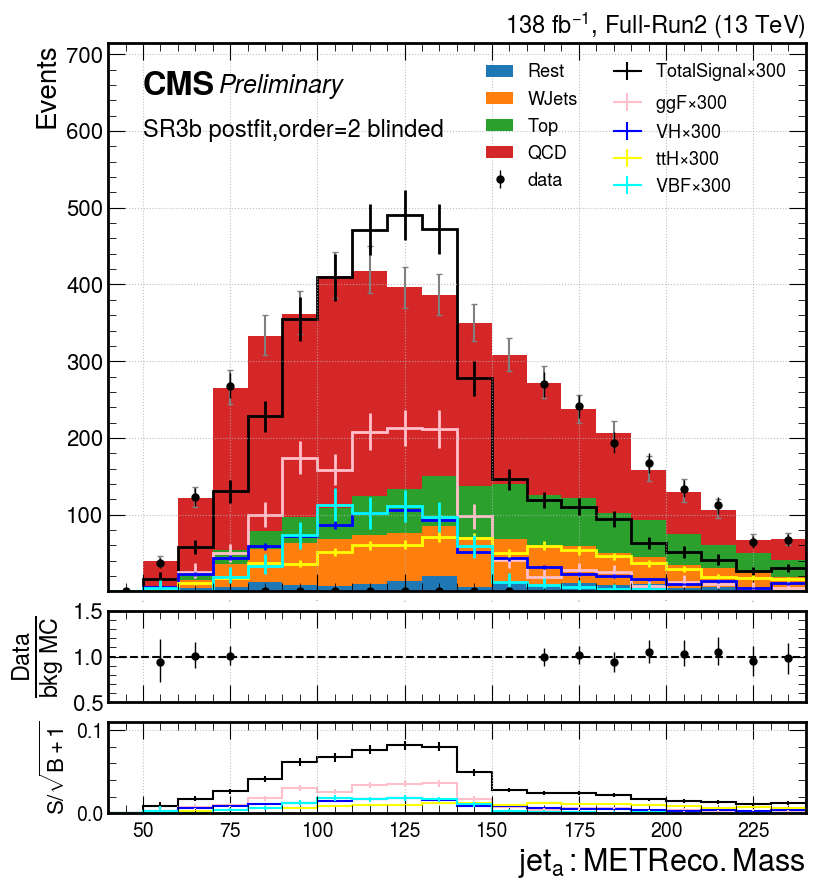

value is  [  0.       104.49596  306.31216  640.236    751.9397   763.7776
 852.50494  804.4265   699.886    614.3782   533.883    413.50922
 348.84515  268.43762  233.4015   143.73315  116.2302    94.17102
  35.880795  53.544445]
variance is  [0.00000000e+00 9.54794588e+01 2.71436630e+02 5.70377003e+02
 1.86264515e-10 1.25914812e-09 1.69873238e-09 9.68575478e-11
 1.94460154e-09 1.77323818e-09 1.10268593e-09 1.32247806e-10
 3.26666334e+02 2.71034046e+02 2.34532265e+02 1.85404657e+02
 1.45760022e+02 1.05554590e+02 6.70601473e+01 6.98713771e+01]


/tmp/ipykernel_939497/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_939497/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_939497/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_939497/1941715827.py:110: RuntimeWarning: invalid value encountered in divide
  ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
/tmp/ipykernel_939497/1941715827.py:111: RuntimeWarning: invalid value encountered in divide
  hep.histplot(h/bkg_h, bins=hist.axes[0].edges, yerr=ratio_error, color='black', histtype='errorbar', density=density, stack=False, ax=ax1)
/tmp/ipykernel_939497/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_939497/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_939497/21

total error: [[ 0.         11.85568025 18.70213186 29.87746218  6.88183794  6.48299372
   7.19130594  7.58409891  9.85858415  6.5180634   8.94186796  8.92319585
  24.58845198 20.9429309  20.60727306 18.3935383  17.31128494 15.49392722
  12.42486775 11.95224083]
 [ 0.         13.0491392  18.70213186 31.23731165  8.40142884  6.48299372
   7.19130594  7.58409891  9.85858415  6.5180634   8.94186796  8.92319585
  24.58845198 20.9429309  21.34715556 18.3935383  17.31128494 15.49392722
  12.42486775 11.95224083]]
Should scale signal *  1569.097076452875
Optimal cut = 3 20 0.06255721244022867


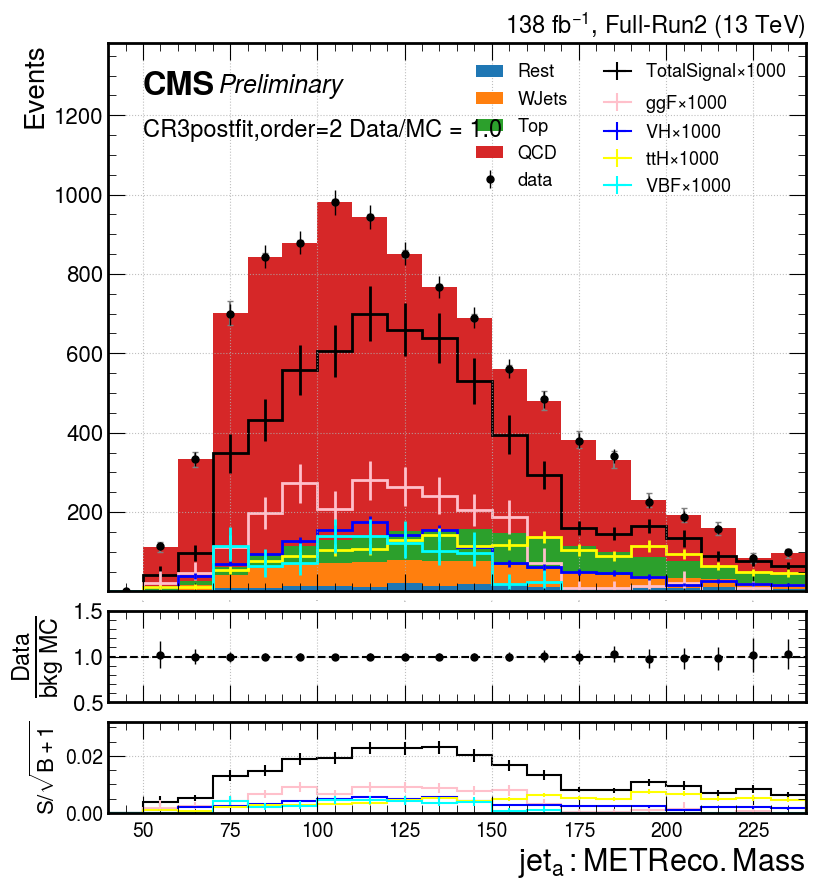

value is  [9.9999997e-05 3.9385539e-01 1.9788742e+00 5.9373136e+00 9.2202892e+00
 1.1682731e+01 1.5660166e+01 1.7254332e+01 1.7148134e+01 1.6890654e+01
 1.6223904e+01 1.3710483e+01 1.2484006e+01 1.0264344e+01 9.4405432e+00
 6.0852776e+00 5.1027865e+00 4.2483931e+00 1.6412015e+00 2.4709628e+00]
variance is  [1.95876369e-23 1.53129674e+01 9.60904455e+01 3.08687460e+02
 3.09294664e+02 2.37000980e+02 2.26288694e+02 1.62982153e+02
 1.07339352e+02 7.77633201e+01 5.89156769e+01 3.70436689e+01
 2.83577400e+01 2.00732907e+01 1.59942435e+01 7.09009139e+00
 5.42841672e+00 4.42395340e+00 1.01029144e+00 2.35703762e+00]


/tmp/ipykernel_939497/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_939497/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_939497/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_939497/1941715827.py:110: RuntimeWarning: invalid value encountered in divide
  ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
/tmp/ipykernel_939497/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_939497/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_939497/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_939497/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_939497/2123

total error: [[4.42579214e-12 7.33265506e-01 3.14790239e+00 7.65045049e+00
  1.07703453e+01 1.44666046e+01 1.53019193e+01 1.37174671e+01
  1.17908747e+01 1.08596422e+01 9.56833312e+00 9.42464744e+00
  9.33607313e+00 6.83493448e+00 7.96058260e+00 5.88603909e+00
  4.39140712e+00 3.69837278e+00 2.31249118e+00 2.85425169e+00]
 [4.42579214e-12 7.21233473e+01 9.16400750e+01 1.00258280e+02
  6.78071941e+01 4.86500185e+01 3.72228447e+01 2.67434776e+01
  1.99499959e+01 1.68923233e+01 1.40528804e+01 1.37984675e+01
  1.43345818e+01 9.48552461e+00 1.20881480e+01 8.24670452e+00
  5.91851341e+00 5.23483342e+00 3.39905151e+00 4.33651739e+00]]
Should scale signal *  61.198924478793685
Optimal cut = 1 11 0.48520985257989485


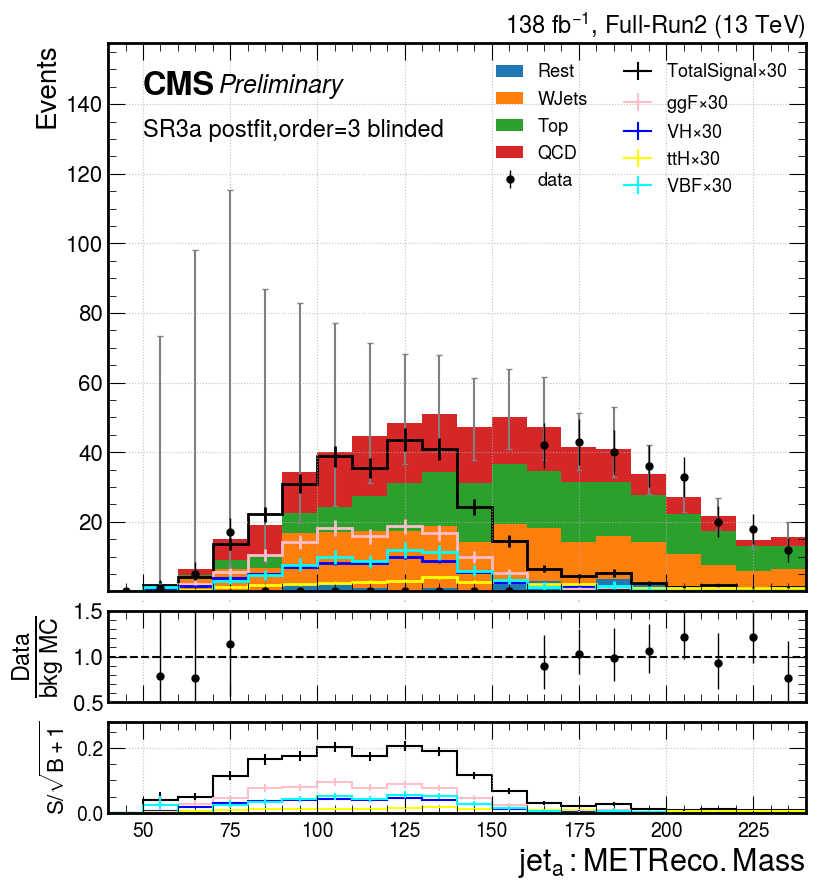

value is  [9.99999975e-05 3.20491638e+01 9.84984360e+01 2.14161957e+02
 2.61656769e+02 2.73989746e+02 3.13852966e+02 3.02978333e+02
 2.69159546e+02 2.41055511e+02 2.13751770e+02 1.69130463e+02
 1.46149933e+02 1.15551605e+02 1.03541916e+02 6.58796539e+01
 5.52511826e+01 4.66215858e+01 1.85005722e+01 2.90048637e+01]
variance is  [2.18110984e-23 1.64899168e+01 8.49349088e+01 3.31692324e+02
 4.29670178e+02 4.81942247e+02 6.49329128e+02 6.20511788e+02
 5.00945606e+02 4.10070205e+02 3.28487281e+02 2.09291352e+02
 2.27099222e+02 1.58589391e+02 1.25475309e+02 7.77291375e+01
 5.92792327e+01 5.01284136e+01 2.04512412e+01 3.57752043e+01]


/tmp/ipykernel_939497/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_939497/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_939497/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_939497/1941715827.py:110: RuntimeWarning: invalid value encountered in divide
  ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
/tmp/ipykernel_939497/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_939497/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_939497/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_939497/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_939497/2123

total error: [[4.67023526e-12 5.84905810e+00 1.28387808e+01 2.32204012e+01
  2.79509202e+01 2.97786390e+01 3.23218187e+01 3.28595120e+01
  2.98993491e+01 2.91743283e+01 2.53764082e+01 2.24070902e+01
  2.21117628e+01 1.96853124e+01 1.71061050e+01 1.58500149e+01
  1.34729456e+01 1.24088340e+01 7.48810102e+00 8.56320818e+00]
 [4.67023526e-12 7.31651010e+00 1.43370361e+01 2.41927530e+01
  2.96610462e+01 3.24223050e+01 3.41001813e+01 3.49926315e+01
  2.98993491e+01 2.91743283e+01 2.72576861e+01 2.40100168e+01
  2.41287034e+01 1.96853124e+01 1.71061050e+01 1.79042897e+01
  1.63534486e+01 1.44031651e+01 7.48810102e+00 8.56320818e+00]]
Should scale signal *  391.6260497503085
Optimal cut = 1 20 0.17482387876516012


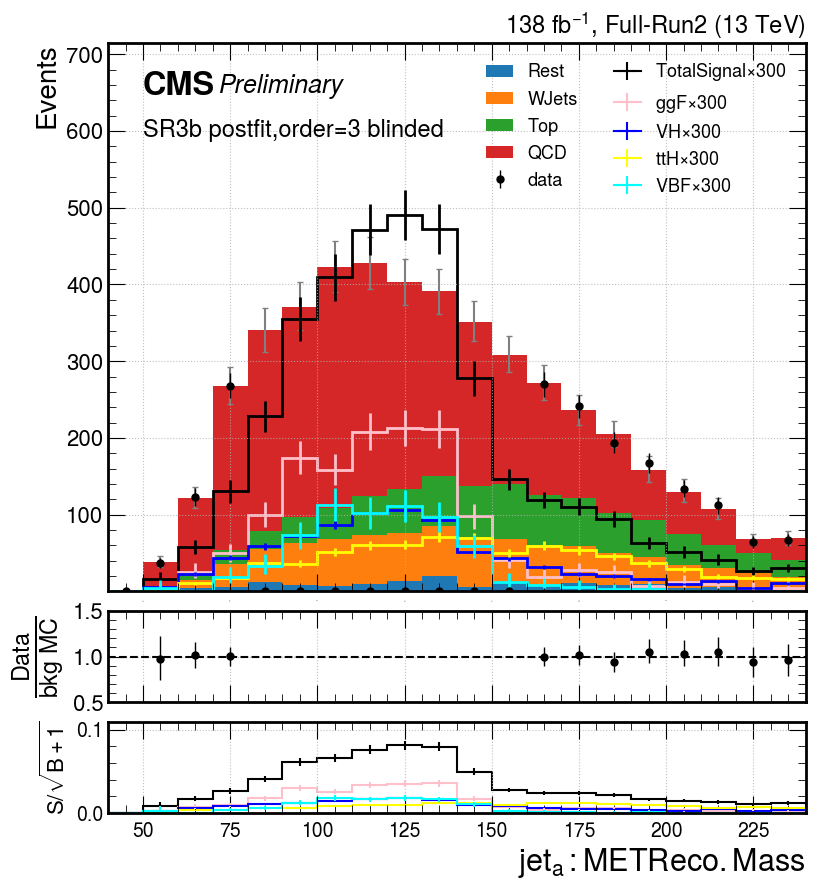

value is  [  0.       105.486465 306.9317   638.3356   751.9397   763.7776
 852.5049   804.4265   699.886    614.3782   533.883    413.50922
 349.08173  268.8906   233.94101  143.9514   116.248085  94.01527
  35.587334  52.968357]
variance is  [0.00000000e+00 8.39355980e+01 2.69904207e+02 5.49478987e+02
 1.93715096e-10 1.39325857e-09 2.05636024e-09 1.41561031e-10
 1.77323818e-09 1.68383121e-09 1.18464231e-09 1.76951289e-10
 3.77972146e+02 3.21842179e+02 2.74729165e+02 1.80413606e+02
 1.40665114e+02 1.18656168e+02 5.77876742e+01 7.55271039e+01]


/tmp/ipykernel_939497/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_939497/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_939497/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_939497/1941715827.py:110: RuntimeWarning: invalid value encountered in divide
  ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
/tmp/ipykernel_939497/1941715827.py:111: RuntimeWarning: invalid value encountered in divide
  hep.histplot(h/bkg_h, bins=hist.axes[0].edges, yerr=ratio_error, color='black', histtype='errorbar', density=density, stack=False, ax=ax1)
/tmp/ipykernel_939497/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_939497/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_939497/21

total error: [[ 0.         11.24595834 18.65555965 29.43586397  6.88183821  6.48299556
   7.19131007  7.58410096  9.85858217  6.51806233  8.94186917  8.92319766
  25.95604519 22.41977909 21.86778262 18.20901396 17.09840575 16.1128922
  11.8376624  12.28396413]
 [ 0.         12.43941728 18.65555965 30.79571343  8.40142911  6.48299556
   7.19131007  7.58410096  9.85858217  6.51806233  8.94186917  8.92319766
  25.95604519 22.41977909 22.60766512 18.20901396 17.09840575 16.1128922
  11.8376624  12.28396413]]
Should scale signal *  1569.1214476963523
Optimal cut = 3 20 0.0625621922303055


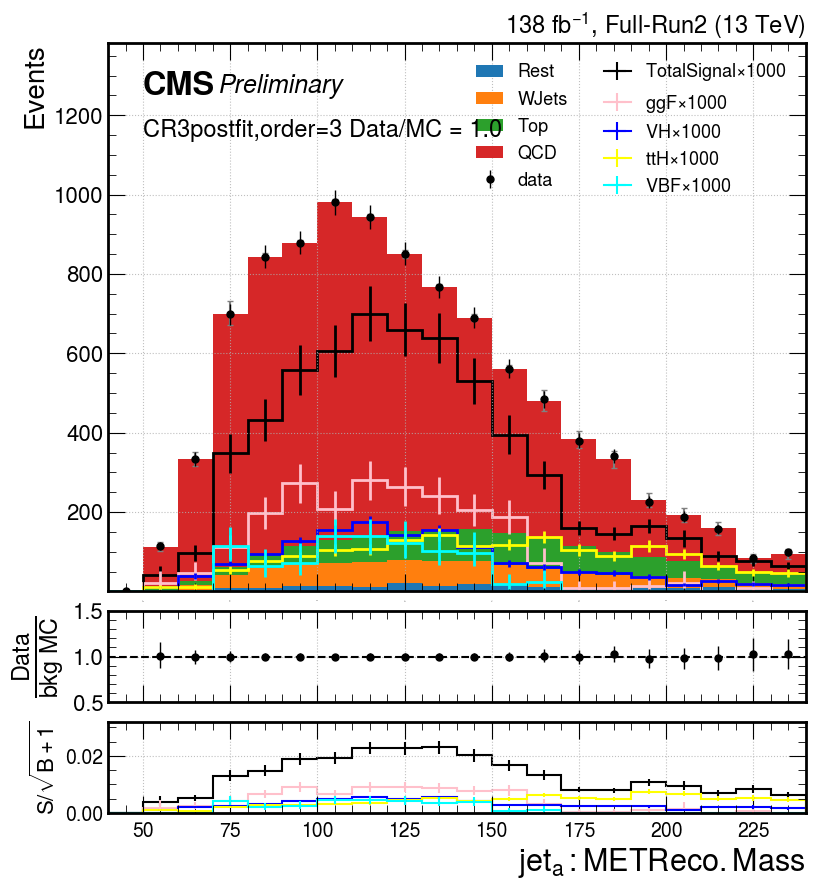

In [11]:
postfit_runPlots(region = "SR1a", othertext = "postfit,order=1",postfit_files = "/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedHWW/combine/scripts/f_test/cards/nTF_1/FitShapes.root")
postfit_runPlots(region = "SR1b", othertext = "postfit,order=1",postfit_files = "/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedHWW/combine/scripts/f_test/cards/nTF_1/FitShapes.root")
postfit_runPlots(region = "CR1",  othertext = "postfit,order=1",postfit_files = "/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedHWW/combine/scripts/f_test/cards/nTF_1/FitShapes.root",blind = False)

postfit_runPlots(region = "SR1a", othertext = "postfit,order=2",postfit_files = "/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedHWW/combine/scripts/f_test/cards/nTF_2/FitShapes.root")
postfit_runPlots(region = "SR1b", othertext = "postfit,order=2",postfit_files = "/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedHWW/combine/scripts/f_test/cards/nTF_2/FitShapes.root")
postfit_runPlots(region = "CR1",  othertext = "postfit,order=2",postfit_files = "/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedHWW/combine/scripts/f_test/cards/nTF_2/FitShapes.root",blind = False)

postfit_runPlots(region = "SR1a", othertext = "postfit,order=3",postfit_files = "/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedHWW/combine/scripts/f_test/cards/nTF_3/FitShapes.root")
postfit_runPlots(region = "SR1b", othertext = "postfit,order=3",postfit_files = "/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedHWW/combine/scripts/f_test/cards/nTF_3/FitShapes.root")
postfit_runPlots(region = "CR1",  othertext = "postfit,order=3",postfit_files = "/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedHWW/combine/scripts/f_test/cards/nTF_3/FitShapes.root",blind = False)

postfit_runPlots(region = "SR2a", othertext = "postfit,order=1",postfit_files = "/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedHWW/combine/scripts/f_test/cards/nTF_1/FitShapes.root")
postfit_runPlots(region = "SR2b", othertext = "postfit,order=1",postfit_files = "/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedHWW/combine/scripts/f_test/cards/nTF_1/FitShapes.root")
postfit_runPlots(region = "CR2",  othertext = "postfit,order=1",postfit_files = "/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedHWW/combine/scripts/f_test/cards/nTF_1/FitShapes.root",blind = False)

postfit_runPlots(region = "SR2a", othertext = "postfit,order=2",postfit_files = "/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedHWW/combine/scripts/f_test/cards/nTF_2/FitShapes.root")
postfit_runPlots(region = "SR2b", othertext = "postfit,order=2",postfit_files = "/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedHWW/combine/scripts/f_test/cards/nTF_2/FitShapes.root")
postfit_runPlots(region = "CR2",  othertext = "postfit,order=2",postfit_files = "/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedHWW/combine/scripts/f_test/cards/nTF_2/FitShapes.root",blind = False)

postfit_runPlots(region = "SR2a", othertext = "postfit,order=3",postfit_files = "/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedHWW/combine/scripts/f_test/cards/nTF_3/FitShapes.root")
postfit_runPlots(region = "SR2b", othertext = "postfit,order=3",postfit_files = "/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedHWW/combine/scripts/f_test/cards/nTF_3/FitShapes.root")
postfit_runPlots(region = "CR2",  othertext = "postfit,order=3",postfit_files = "/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedHWW/combine/scripts/f_test/cards/nTF_3/FitShapes.root",blind = False)

postfit_runPlots(region = "SR3a", othertext = "postfit,order=1",postfit_files = "/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedHWW/combine/scripts/f_test/cards/nTF_1/FitShapes.root")
postfit_runPlots(region = "SR3b", othertext = "postfit,order=1",postfit_files = "/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedHWW/combine/scripts/f_test/cards/nTF_1/FitShapes.root")
postfit_runPlots(region = "CR3",  othertext = "postfit,order=1",postfit_files = "/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedHWW/combine/scripts/f_test/cards/nTF_1/FitShapes.root",blind = False)

postfit_runPlots(region = "SR3a", othertext = "postfit,order=2",postfit_files = "/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedHWW/combine/scripts/f_test/cards/nTF_2/FitShapes.root")
postfit_runPlots(region = "SR3b", othertext = "postfit,order=2",postfit_files = "/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedHWW/combine/scripts/f_test/cards/nTF_2/FitShapes.root")
postfit_runPlots(region = "CR3",  othertext = "postfit,order=2",postfit_files = "/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedHWW/combine/scripts/f_test/cards/nTF_2/FitShapes.root",blind = False)

postfit_runPlots(region = "SR3a", othertext = "postfit,order=3",postfit_files = "/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedHWW/combine/scripts/f_test/cards/nTF_3/FitShapes.root")
postfit_runPlots(region = "SR3b", othertext = "postfit,order=3",postfit_files = "/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedHWW/combine/scripts/f_test/cards/nTF_3/FitShapes.root")
postfit_runPlots(region = "CR3",  othertext = "postfit,order=3",postfit_files = "/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedHWW/combine/scripts/f_test/cards/nTF_3/FitShapes.root",blind = False)

### some other test

In [12]:
#